In [1]:
import warnings
import opendatasets as od
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import MSTL

sns.set(style="white", palette="muted", color_codes=True)

warnings.filterwarnings("ignore")

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20

In [2]:
# od.download("https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data")

In [3]:
folder = "store-sales-time-series-forecasting"

datasets = [
    folder + "/" + f for f in os.listdir('store-sales-time-series-forecasting')
]

In [4]:
datasets

['store-sales-time-series-forecasting/holidays_events.csv',
 'store-sales-time-series-forecasting/oil.csv',
 'store-sales-time-series-forecasting/sample_submission.csv',
 'store-sales-time-series-forecasting/stores.csv',
 'store-sales-time-series-forecasting/test.csv',
 'store-sales-time-series-forecasting/train.csv',
 'store-sales-time-series-forecasting/transactions.csv']

#### holidays_events

In [5]:
holiday_df = pd.read_csv(datasets[0], parse_dates=["date"])

In [6]:
for col in holiday_df.columns[1:]:
    print(col)
    print("*" * len(col))
    print(holiday_df[col].value_counts())
    print()

type
****
Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: type, dtype: int64

locale
******
National    174
Local       152
Regional     24
Name: locale, dtype: int64

locale_name
***********
Ecuador                           174
Quito                              13
Riobamba                           12
Guaranda                           12
Latacunga                          12
Ambato                             12
Guayaquil                          11
Cuenca                              7
Ibarra                              7
Salinas                             6
Loja                                6
Santa Elena                         6
Santo Domingo de los Tsachilas      6
Quevedo                             6
Manta                               6
Esmeraldas                          6
Cotopaxi                            6
El Carmen                           6
Santo Domingo                       6
Machala             

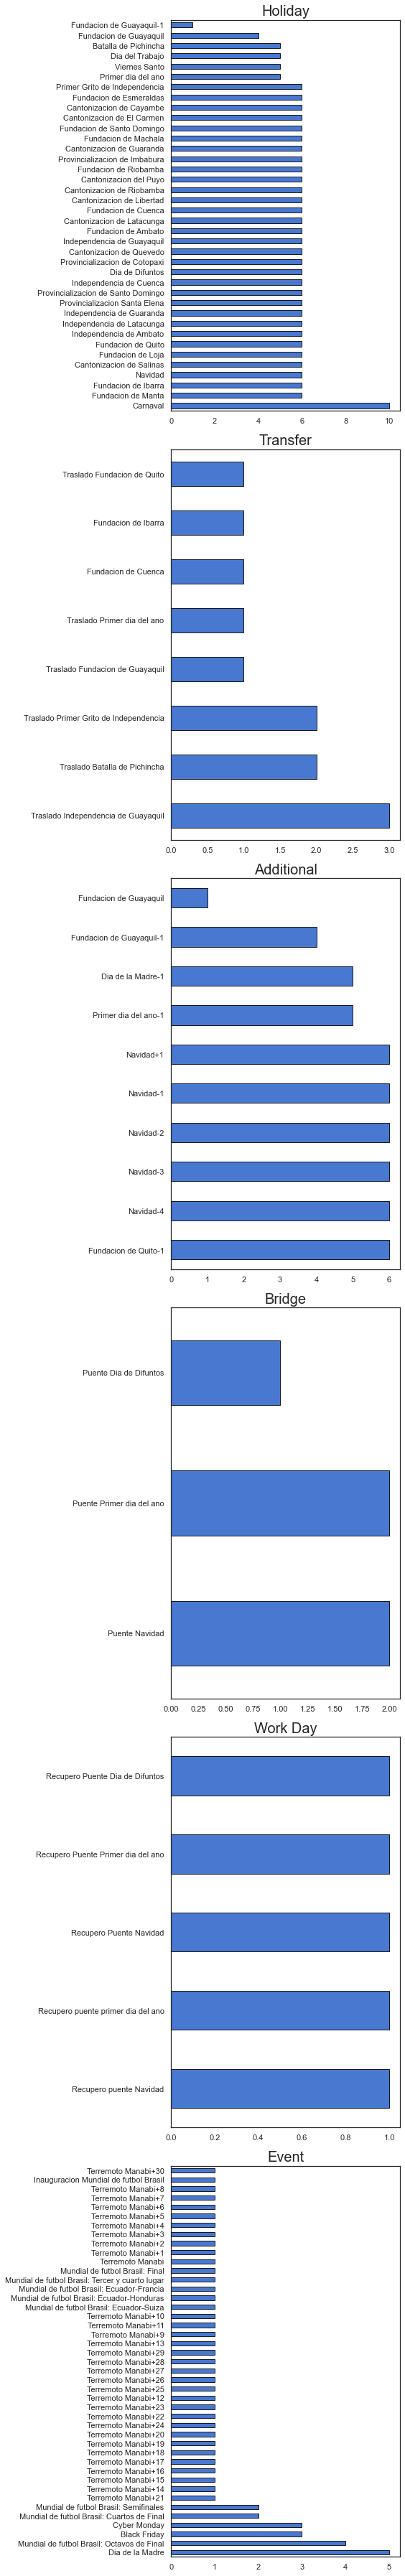

In [7]:
fig, axes = plt.subplots(6, 1, figsize=(8, 50), tight_layout=True)

for name, ax in zip(holiday_df["type"].unique(), axes.flatten()):

    holiday_df.loc[holiday_df["type"].eq(name), "description"].value_counts().\
        plot(kind="barh", ax=ax, edgecolor="k")

    ax.set_title(name)

"Holidays" are official holidays that repeats every year. Additional holidays usually occurs before and/or after the official holidays. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. 

Events are not exactly holidays special events that probably affect the sales. The main events here are Football, earthquake in manabi, Monthers day, black friday and cyber monday. 

In [8]:
holiday_df.query("description == 'Cyber Monday'")

date   type    locale locale_name   description  transferred
145 2014-12-01  Event  National     Ecuador  Cyber Monday        False
199 2015-11-30  Event  National     Ecuador  Cyber Monday        False
285 2016-11-28  Event  National     Ecuador  Cyber Monday        False

In [9]:
holiday_df.query("description == 'Black Friday'")

date   type    locale locale_name   description  transferred
144 2014-11-28  Event  National     Ecuador  Black Friday        False
198 2015-11-27  Event  National     Ecuador  Black Friday        False
284 2016-11-25  Event  National     Ecuador  Black Friday        False

In [10]:
holiday_df.query("description.str.contains(r'Madre')")

date        type    locale locale_name        description  \
53  2013-05-11  Additional  National     Ecuador  Dia de la Madre-1   
55  2013-05-12       Event  National     Ecuador    Dia de la Madre   
102 2014-05-10  Additional  National     Ecuador  Dia de la Madre-1   
103 2014-05-11       Event  National     Ecuador    Dia de la Madre   
171 2015-05-09  Additional  National     Ecuador  Dia de la Madre-1   
172 2015-05-10       Event  National     Ecuador    Dia de la Madre   
242 2016-05-07  Additional  National     Ecuador  Dia de la Madre-1   
245 2016-05-08       Event  National     Ecuador    Dia de la Madre   
310 2017-05-13  Additional  National     Ecuador  Dia de la Madre-1   
311 2017-05-14       Event  National     Ecuador    Dia de la Madre   

     transferred  
53         False  
55         False  
102        False  
103        False  
171        False  
172        False  
242        False  
245        False  
310        False  
311        False

### oil

In [11]:
oil_df = pd.read_csv(datasets[1], parse_dates=["date"], index_col="date")

In [12]:
oil_df.info()  # some missing values exists

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1218 entries, 2013-01-01 to 2017-08-31
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dcoilwtico  1175 non-null   float64
dtypes: float64(1)
memory usage: 19.0 KB


In [13]:
oil_df.isna().sum()  # 43 missing values

dcoilwtico    43
dtype: int64

In [14]:
oil_df.index.freq = "B"  # setting data frequency to business days

In [15]:
oil_df.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-07', '2013-01-08', '2013-01-09', '2013-01-10',
               '2013-01-11', '2013-01-14',
               ...
               '2017-08-18', '2017-08-21', '2017-08-22', '2017-08-23',
               '2017-08-24', '2017-08-25', '2017-08-28', '2017-08-29',
               '2017-08-30', '2017-08-31'],
              dtype='datetime64[ns]', name='date', length=1218, freq='B')

<AxesSubplot:xlabel='date'>

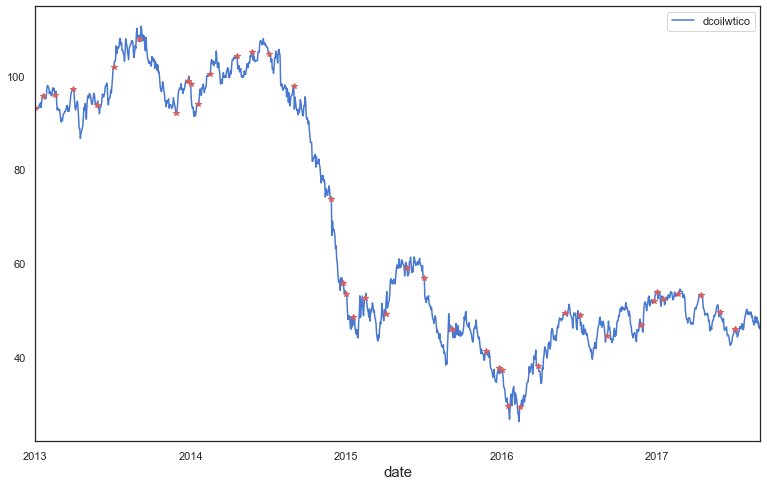

In [16]:
oil_df_imputed = oil_df.fillna(method="ffill").fillna(method="bfill")

ax = oil_df_imputed.plot(figsize=(13, 8), linestyle="-")

oil_df_imputed[oil_df.isnull()].plot(ax=ax,
                                     legend=None,
                                     marker="*",
                                     color="r",
                                     linestyle="-")

### stores

In [17]:
store_df = pd.read_csv(datasets[3])
store_df

store_nbr           city                           state type  cluster
0           1          Quito                       Pichincha    D       13
1           2          Quito                       Pichincha    D       13
2           3          Quito                       Pichincha    D        8
3           4          Quito                       Pichincha    D        9
4           5  Santo Domingo  Santo Domingo de los Tsachilas    D        4
5           6          Quito                       Pichincha    D       13
6           7          Quito                       Pichincha    D        8
7           8          Quito                       Pichincha    D        8
8           9          Quito                       Pichincha    B        6
9          10          Quito                       Pichincha    C       15
10         11        Cayambe                       Pichincha    B        6
11         12      Latacunga                        Cotopaxi    C       15
12         13      Latacunga                        Cotopaxi    C       15
13         14       Riobamba                      Chimborazo    C        7
14         15         Ibarra                        Imbabura    C       15
15         16  Santo Domingo  Santo Domingo de los Tsachilas    C        3
16         17          Quito                       Pichincha    C       12
17         18          Quito                       Pichincha    B       16
18         19       Guaranda                         Bolivar    C       15
19         20          Quito                       Pichincha    B        6
20         21  Santo Domingo  Santo Domingo de los Tsachilas    B        6
21         22           Puyo                         Pastaza    C        7
22         23         Ambato                      Tungurahua    D        9
23         24      Guayaquil                          Guayas    D        1
24         25        Salinas                     Santa Elena    D        1
25         26      Guayaquil                          Guayas    D       10
26         27          Daule                          Guayas    D        1
27         28      Guayaquil                          Guayas    E       10
28         29      Guayaquil                          Guayas    E       10
29         30      Guayaquil                          Guayas    C        3
30         31       Babahoyo                        Los Rios    B       10
31         32      Guayaquil                          Guayas    C        3
32         33        Quevedo                        Los Rios    C        3
33         34      Guayaquil                          Guayas    B        6
34         35         Playas                          Guayas    C        3
35         36       Libertad                          Guayas    E       10
36         37         Cuenca                           Azuay    D        2
37         38           Loja                            Loja    D        4
38         39         Cuenca                           Azuay    B        6
39         40        Machala                          El Oro    C        3
40         41        Machala                          El Oro    D        4
41         42         Cuenca                           Azuay    D        2
42         43     Esmeraldas                      Esmeraldas    E       10
43         44          Quito                       Pichincha    A        5
44         45          Quito                       Pichincha    A       11
45         46          Quito                       Pichincha    A       14
46         47          Quito                       Pichincha    A       14
47         48          Quito                       Pichincha    A       14
48         49          Quito                       Pichincha    A       11
49         50         Ambato                      Tungurahua    A       14
50         51      Guayaquil                          Guayas    A       17
51         52          Manta                          Manabi    A       11
52         53          Manta 

In [18]:
for col in store_df.columns[1:]:
    print(col)
    print("*" * len(col))
    print(store_df[col].value_counts())
    print()

city
****
Quito            18
Guayaquil         8
Cuenca            3
Santo Domingo     3
Manta             2
Latacunga         2
Machala           2
Ambato            2
Quevedo           1
Esmeraldas        1
Loja              1
Libertad          1
Playas            1
Daule             1
Babahoyo          1
Salinas           1
Puyo              1
Guaranda          1
Ibarra            1
Riobamba          1
Cayambe           1
El Carmen         1
Name: city, dtype: int64

state
*****
Pichincha                         19
Guayas                            11
Santo Domingo de los Tsachilas     3
Azuay                              3
Manabi                             3
Cotopaxi                           2
Tungurahua                         2
Los Rios                           2
El Oro                             2
Chimborazo                         1
Imbabura                           1
Bolivar                            1
Pastaza                            1
Santa Elena                    

Most of the stores are located in Quito, the capital of Ecuador

In [19]:
np.sort(store_df["store_nbr"].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54], dtype=int64)

### Train

In [20]:
# train_df = ps.read_csv(datasets[5])
# ps.to_datetime(train_df["date"])

In [21]:
train_df = pd.read_csv(datasets[5], parse_dates=["date"]).drop("id", axis=1)

In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   sales        float64       
 4   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 114.5+ MB


In [23]:
train_df.isnull().sum()  # No null values

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [24]:
print(train_df["family"].unique())
print(len(train_df["family"].unique()))

# 33 products for each store

['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']
33


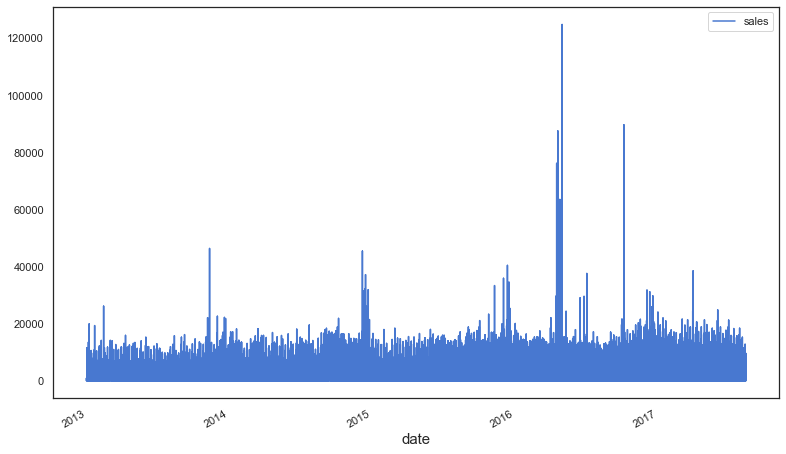

In [25]:
train_df.set_index("date").plot(y="sales", figsize=(13, 8));

In [26]:
# Extracting extra freatures from date columns

train_df["day"] = train_df["date"].dt.day
train_df["month"] = train_df["date"].dt.month
train_df["quarter"] = train_df["date"].dt.quarter
train_df["year"] = train_df["date"].dt.year
train_df["day_of_week"] = train_df["date"].dt.dayofweek
train_df["day_of_year"] = train_df["date"].dt.dayofyear
train_df["is_weekend"] = train_df["date"].dt.dayofweek > 4

train_df.head()

date  store_nbr      family  sales  onpromotion  day  month  quarter  \
0 2013-01-01          1  AUTOMOTIVE    0.0            0    1      1        1   
1 2013-01-01          1   BABY CARE    0.0            0    1      1        1   
2 2013-01-01          1      BEAUTY    0.0            0    1      1        1   
3 2013-01-01          1   BEVERAGES    0.0            0    1      1        1   
4 2013-01-01          1       BOOKS    0.0            0    1      1        1   

   year  day_of_week  day_of_year  is_weekend  
0  2013            1            1       False  
1  2013            1            1       False  
2  2013            1            1       False  
3  2013            1            1       False  
4  2013            1            1       False

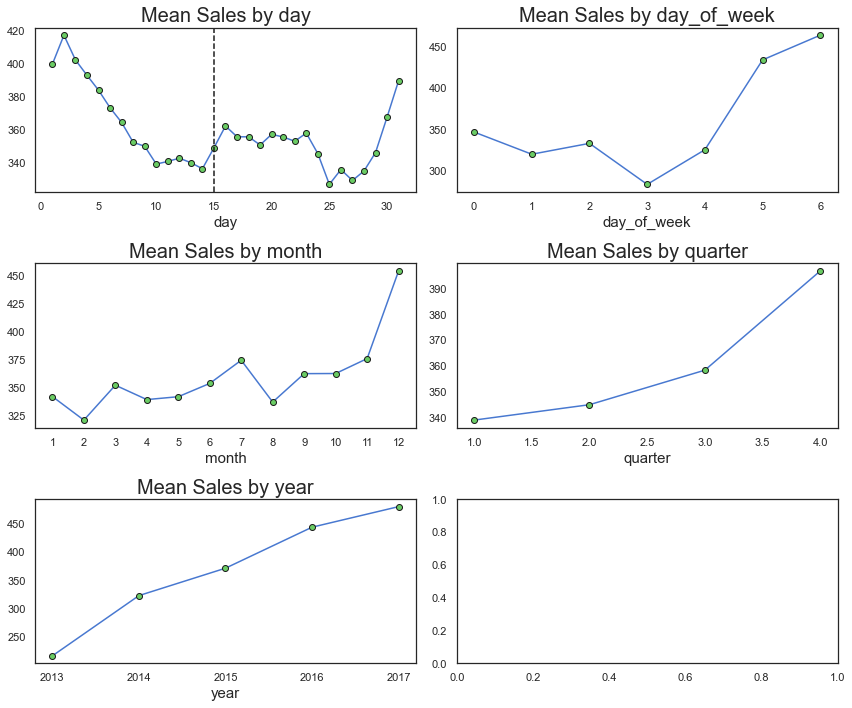

In [27]:
fig, axes = plt.subplots(3, 2, tight_layout=True, figsize=(12, 10))

for col, ax in zip(["day", "day_of_week", "month", "quarter", "year"], axes.flatten()):

    train_df.groupby(col)["sales"].mean().plot(
        ax=ax, marker="o", mfc="g", mec="k")
    ax.set_title(f"Mean Sales by {col}")

    if col in ["year", "month"]:
        ax.set_xticks(train_df.groupby(col)["sales"].mean().index)

    if col == "day":
        ax.axvline(15, linestyle="--", color="k")

*  *Daily Seasonality*: In a month, there is an increase in mean sales after 15th, then it dips down and then increases significantly at the end of the month and continues till the first couple of days of the next month.


* *Monthly Seasonality*: In a year, Sales are very high during December and the falls rapidly down on January.


* *Yearly Seasonality*: There is an increase in mean sales every year.


* *Weekly Seasonality*: In a week, Sales are very high during the weekends and lowest on thursday.

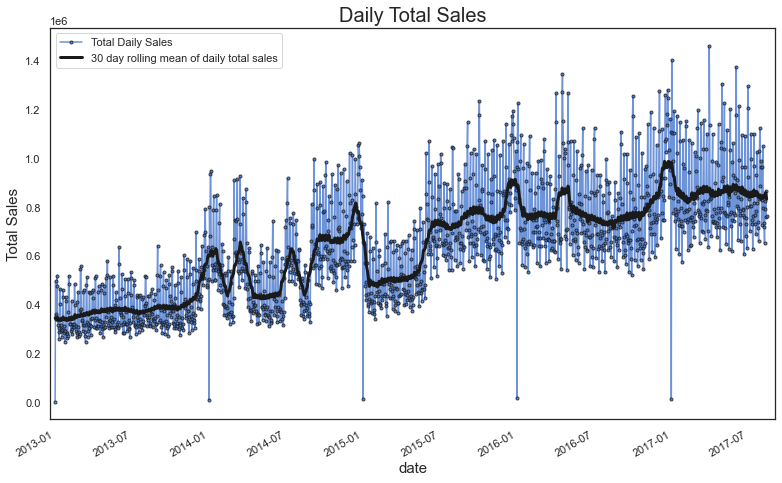

In [28]:
total_daily_sales = train_df.groupby("date")["sales"].sum()

ax = total_daily_sales.plot(y="sales",
                            figsize=(13, 8),
                            marker=".",
                            alpha=0.8,
                            mec='k',
                            legend=None)

total_daily_sales.rolling(window=30, min_periods=7, center=True).mean().\
    plot(ax=ax, lw=3, color="k", legend=None)

plt.legend(
    labels=["Total Daily Sales", "30 day rolling mean of daily total sales"])

plt.title("Daily Total Sales")
plt.ylabel("Total Sales")
plt.xlim("2012-12-20", "2017-09-05");

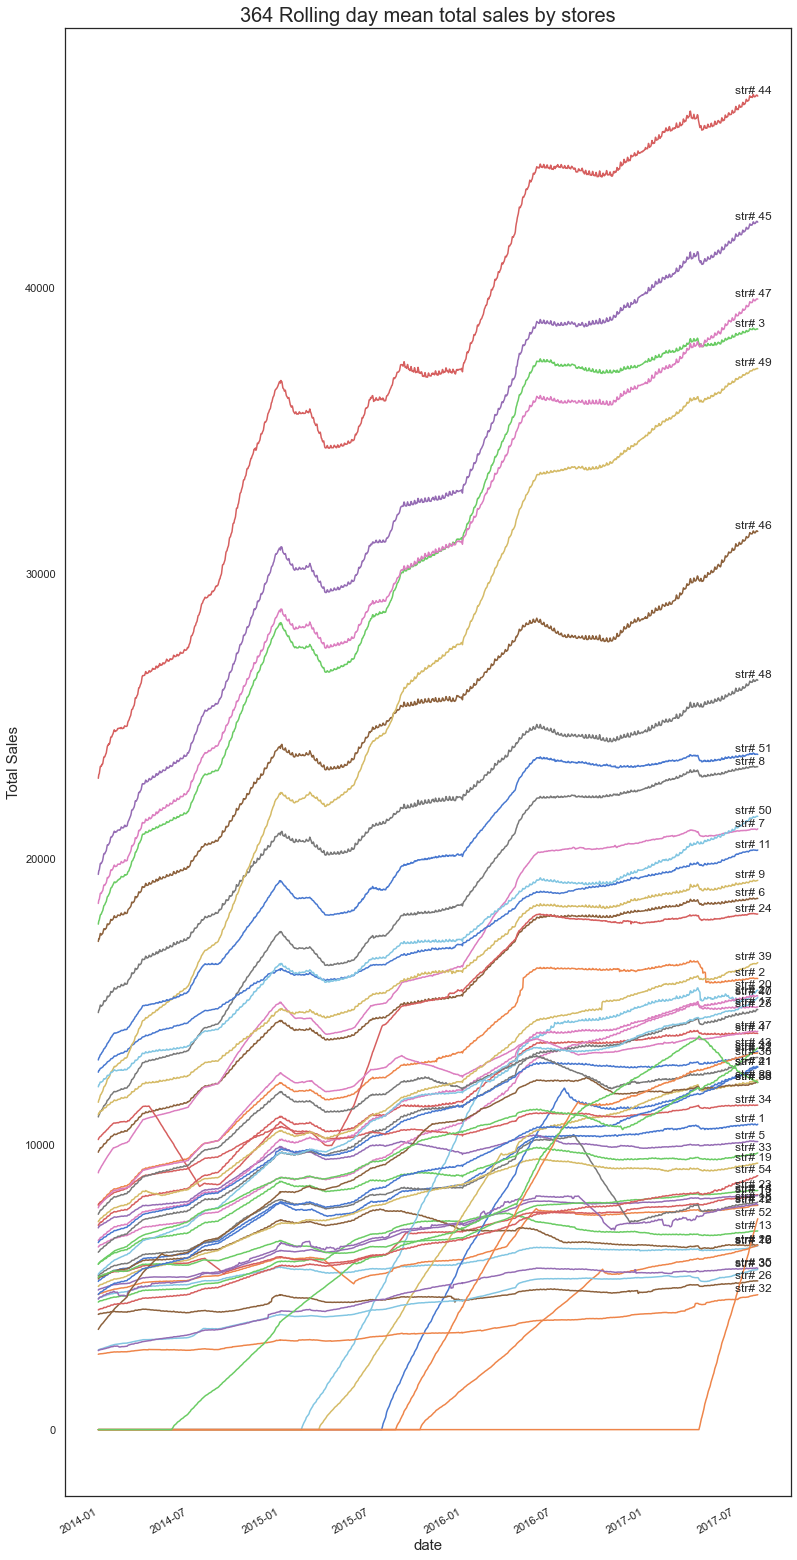

In [29]:
store_total_dly_sales = \
    train_df.groupby(["store_nbr", "date"], as_index=False)["sales"].sum()

fig, ax = plt.subplots(figsize=(13, 30))
roll_period = 365

for store in store_total_dly_sales["store_nbr"].unique():

    roll_mean = \
        store_total_dly_sales.query(f"store_nbr == {store}").set_index("date").\
        rolling(roll_period)["sales"].mean().to_frame(f"{store}")

    roll_mean.plot(ax=ax, legend=None)

    xy_coord = roll_mean.reset_index().iloc[-1, :].values

    ax.annotate(text=f"str# {store}",
                xy=xy_coord,
                xytext=xy_coord + np.array([-pd.Timedelta("45 days"), 100]))

plt.ylabel("Total Sales")
plt.title("364 Rolling day mean total sales by stores");

From the above plot, it is clear that sales across stores differs a lot. Some stores perform very well.

Text(0, 0.5, 'Store Number')

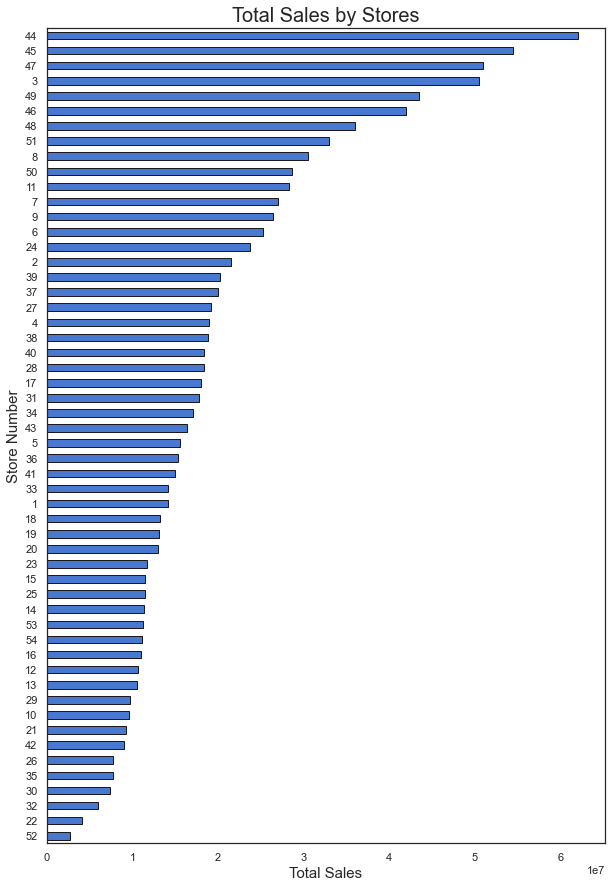

In [30]:
fig, ax = plt.subplots(figsize=(10, 15))

train_df.groupby("store_nbr")["sales"].sum().sort_values().\
    plot(kind="barh", ax=ax, edgecolor="k", title="Total Sales by Stores")

ax.set_xlabel("Total Sales")
ax.set_ylabel("Store Number")

In [31]:
train_df = train_df.merge(store_df, on="store_nbr", how="left")

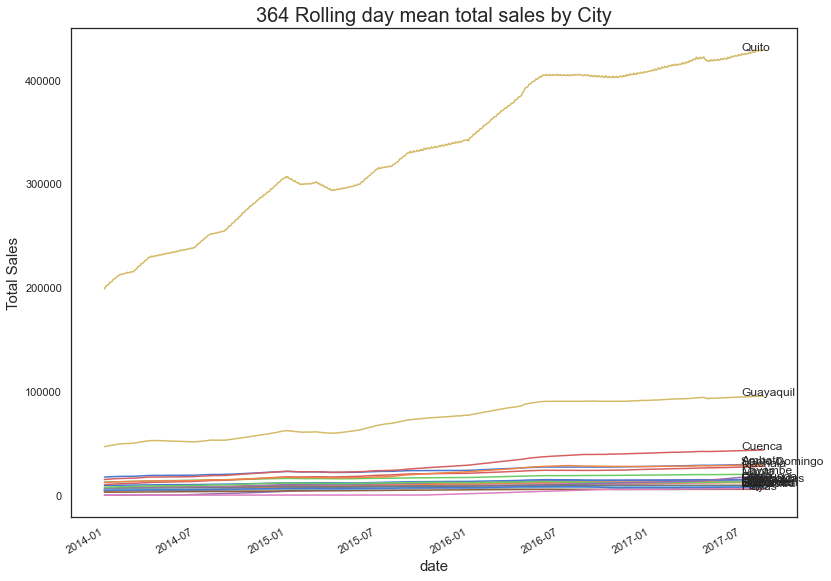

In [32]:
city_dly_sales = train_df.groupby(
    ["city", "date"], as_index=False)["sales"].sum()

fig, ax = plt.subplots(figsize=(13, 10))
roll_period = 365

for city in city_dly_sales["city"].unique():

    roll_mean = \
        city_dly_sales.query(f"city == '{city}'").set_index("date").\
        rolling(roll_period)["sales"].mean().to_frame(f"{city}")

    roll_mean.plot(ax=ax, legend=None)

    xy_coord = roll_mean.reset_index().iloc[-1, :].values

    ax.annotate(text=city,
                xy=xy_coord,
                xytext=xy_coord + np.array([-pd.Timedelta("45 days"), 100]))

plt.ylabel("Total Sales")
plt.title("364 Rolling day mean total sales by City");

The city of *Quito* has the highest total sales compared to any other cities.

Text(0.5, 1.0, '364 Rolling day mean total sales by state')

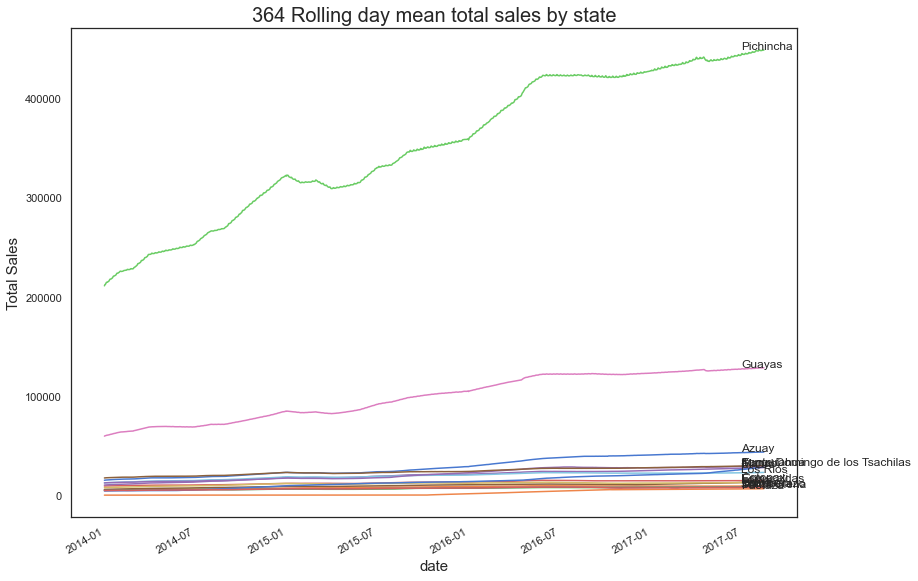

In [33]:
state_dly_sales = train_df.groupby(
    ["state", "date"], as_index=False)["sales"].sum()

fig, ax = plt.subplots(figsize=(13, 10))
roll_period = 365

for state in state_dly_sales["state"].unique():

    roll_mean = \
        state_dly_sales.query(f"state == '{state}'").set_index("date").\
        rolling(roll_period)["sales"].mean().to_frame(f"{state}")

    roll_mean.plot(ax=ax, legend=None)

    xy_coord = roll_mean.reset_index().iloc[-1, :].values

    ax.annotate(text=state,
                xy=xy_coord,
                xytext=xy_coord + np.array([-pd.Timedelta("45 days"), 100]))

plt.ylabel("Total Sales")
plt.title("364 Rolling day mean total sales by state")

In [34]:
store_df.groupby(["state", "city"])["store_nbr"].count()

state                           city         
Azuay                           Cuenca            3
Bolivar                         Guaranda          1
Chimborazo                      Riobamba          1
Cotopaxi                        Latacunga         2
El Oro                          Machala           2
Esmeraldas                      Esmeraldas        1
Guayas                          Daule             1
                                Guayaquil         8
                                Libertad          1
                                Playas            1
Imbabura                        Ibarra            1
Loja                            Loja              1
Los Rios                        Babahoyo          1
                                Quevedo           1
Manabi                          El Carmen         1
                                Manta             2
Pastaza                         Puyo              1
Pichincha                       Cayambe           1
                  

Text(0.5, 1.0, '364 Rolling day mean total sales by family')

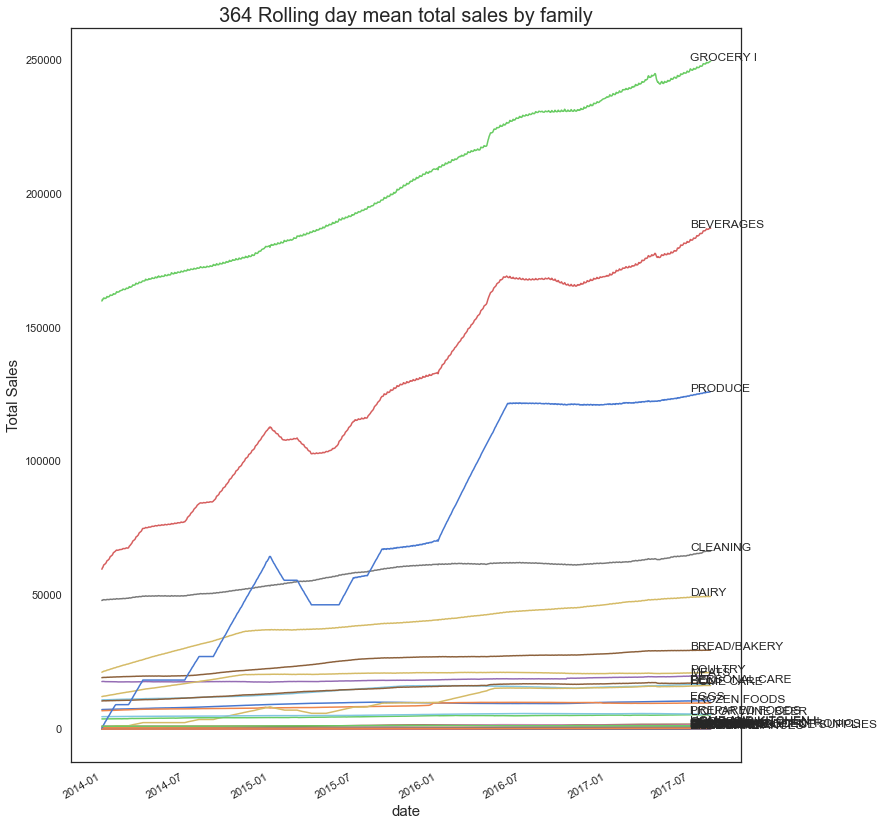

In [35]:
family_total_dly_sales = \
    train_df.groupby(["family", "date"], as_index=False)["sales"].sum()

fig, ax = plt.subplots(figsize=(12, 15))
roll_period = 365

for prd in family_total_dly_sales["family"].unique():

    roll_mean = \
        family_total_dly_sales.query(f"family == '{prd}'").set_index("date").\
        rolling(roll_period)["sales"].mean().to_frame(f"{prd}")

    roll_mean.plot(ax=ax, legend=None)

    xy_coord = roll_mean.reset_index().iloc[-1, :].values

    ax.annotate(text=prd,
                xy=xy_coord,
                xytext=xy_coord + np.array([-pd.Timedelta("45 days"), 100]))

plt.ylabel("Total Sales")
plt.title("364 Rolling day mean total sales by family")

Text(0, 0.5, 'family')

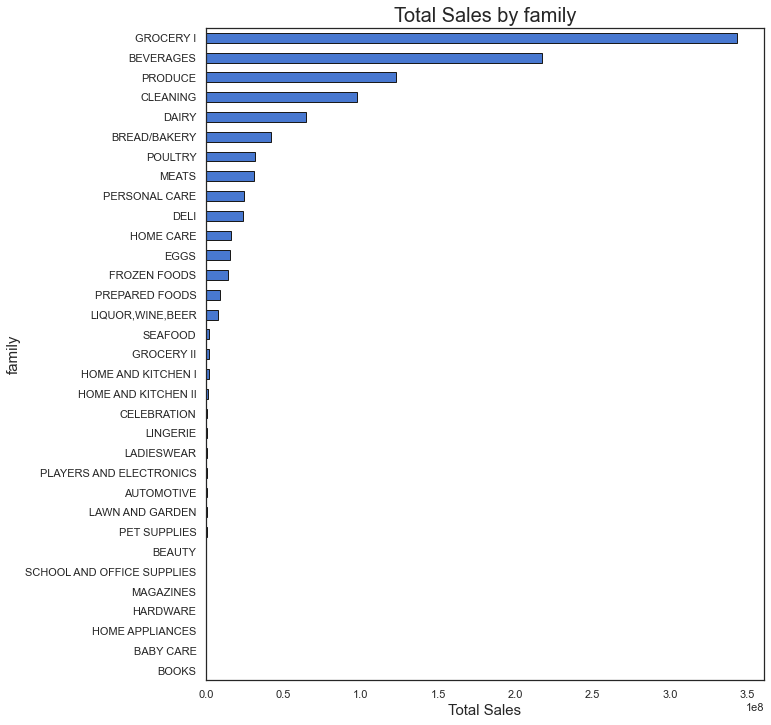

In [36]:
fig, ax = plt.subplots(figsize=(10, 12))

train_df.groupby("family")["sales"].sum().sort_values().\
    plot(kind="barh", ax=ax, edgecolor="k", title="Total Sales by family")

ax.set_xlabel("Total Sales")
ax.set_ylabel("family")

The most selling product family is Grocery I, followed by beverages and produce.

# Visualizing Total Sales by type of days

In [37]:
# Creating variables for each type of day

weekends = set(train_df.loc[train_df["is_weekend"], "date"])

#Events
earthquake = set(holiday_df.loc[holiday_df["description"].str.contains(r'Terremoto Manabi'),"date"])
futbol = set(holiday_df.loc[holiday_df["description"].str.contains(r'futbol'),"date"])
moms_day = set(holiday_df.query("description.str.contains(r'Dia de la Madre')")["date"])
blk_fri = set(holiday_df.query("description.str.contains(r'Black Friday')")["date"])
cyb_mon = set(holiday_df.query("description.str.contains(r'Cyber Monday')")["date"])

#Holidays
transfer_dates = set(holiday_df.loc[holiday_df["type"].eq("Transfer"), "date"])
christmas = set(holiday_df.loc[holiday_df["description"].str.contains(r'navidad', case=False), "date"])

national_holidays_1 = earthquake.union(cyb_mon, blk_fri, moms_day, christmas, transfer_dates, futbol)

national_holidays_2 = \
    set(
        holiday_df.loc[
            ~holiday_df["date"].isin(national_holidays_1) & holiday_df["locale"].eq("National"), 
            "date"
        ]
    )

reg_holidays = set(holiday_df.query("locale=='Regional'")["date"])
local_holidays = set(holiday_df.query("locale=='Local'")["date"])

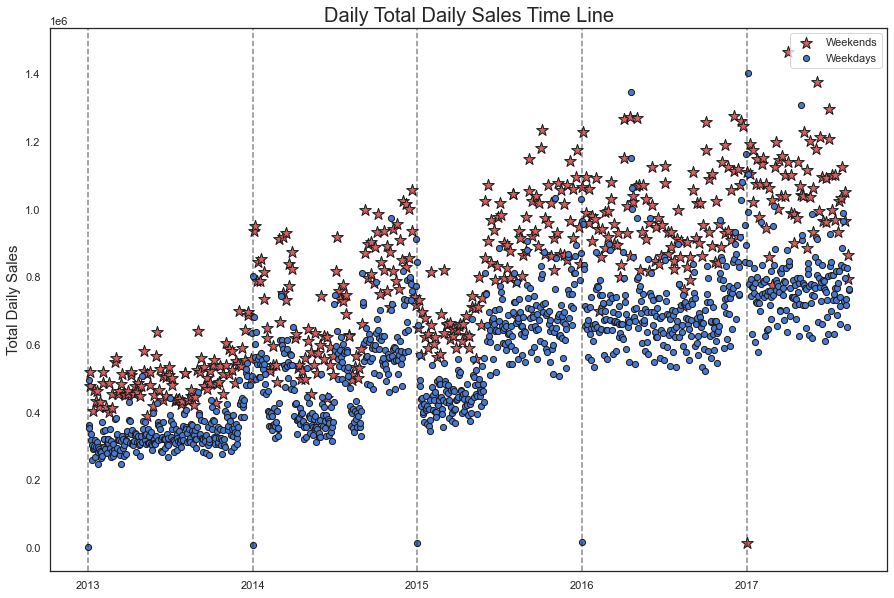

In [38]:
fig, ax = plt.subplots(figsize=(15, 10))

args = dict(x="date",
            y="sales",
            kind="scatter",
            edgecolor="k",
            ax=ax,
            s=150)

# weekends
total_daily_sales[total_daily_sales.index.isin(weekends)].reset_index().\
    plot(**args, marker="*", color="r", label="Weekends")

# Weekdays
total_daily_sales[~total_daily_sales.index.isin(weekends)
                  & ~total_daily_sales.index.isin(christmas)].reset_index(
).plot(**args, color="b", label="Weekdays", marker=".")

ax.set_ylabel("Total Daily Sales")
ax.set_xlabel("")
ax.set_title("Daily Total Daily Sales Time Line")

for newyear in pd.date_range("2013-01-01", "2017-01-01", freq="YS"):
    ax.axvline(newyear, color="k", alpha=0.5, ls="--")

The above plot show the daily total sales (regardless of any stores). The plots illustrates that sales on weekdays are significantly lower than sales on weekends. The sales falls to the lowest during New Year - be it on a weekday or weekend.

Now, I will add certain holidays over the plot and see how sales are affected according to the type of holiday/event.

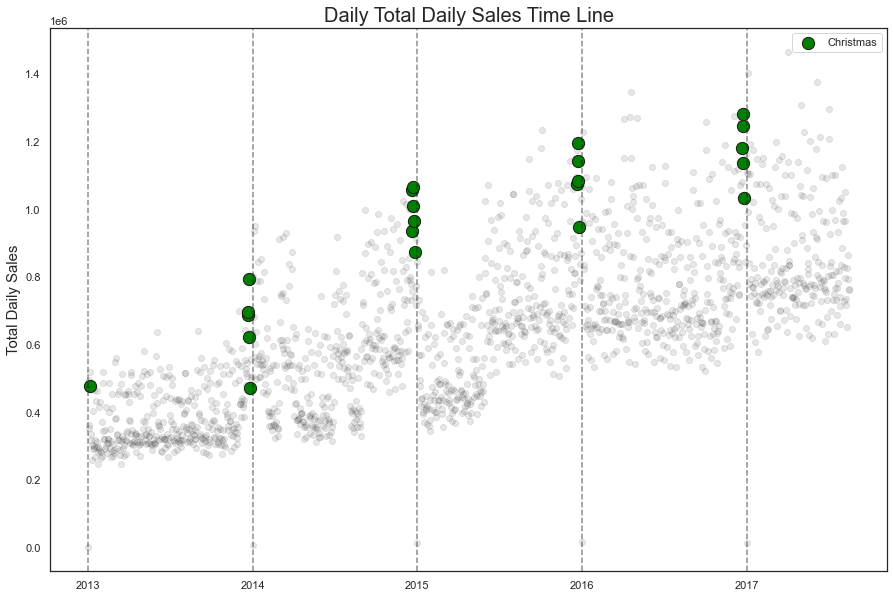

In [39]:
fig, ax = plt.subplots(figsize=(15, 10))

args = dict(x="date",
            y="sales",
            kind="scatter",
            edgecolor="k",
            ax=ax,
            s=150)


total_daily_sales.reset_index().plot(**args, marker=".", alpha=0.1, color="k")

# christmas
total_daily_sales[total_daily_sales.index.isin(christmas)].reset_index().\
    plot(**args, color="green", label="Christmas")


ax.set_ylabel("Total Daily Sales")
ax.set_xlabel("")
ax.set_title("Daily Total Daily Sales Time Line")

for newyear in pd.date_range("2013-01-01", "2017-01-01", freq="YS"):
    ax.axvline(newyear, color="k", alpha=0.5, ls="--")

During Christmas days (additional days and actual chistmas day, from 21 to 26 Dec), there is sharp increase in sales.

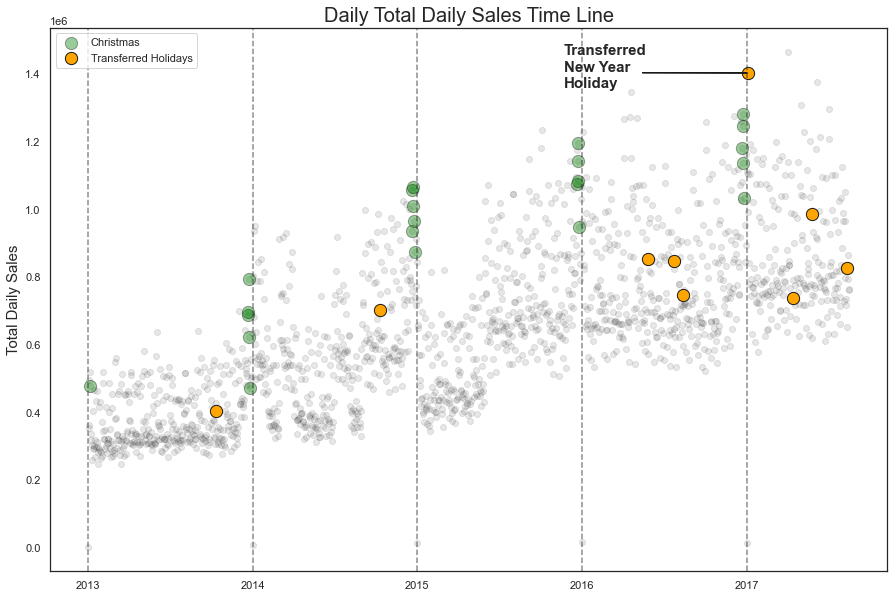

In [40]:
fig, ax = plt.subplots(figsize=(15, 10))

args = dict(x="date",
            y="sales",
            kind="scatter",
            edgecolor="k",
            ax=ax,
            s=150)

total_daily_sales.reset_index().plot(**args, marker=".", alpha=0.1, color="k")

# christmas
total_daily_sales[total_daily_sales.index.isin(christmas)].reset_index().\
    plot(**args, color="green", label="Christmas", alpha=0.4)

# Transferred Holidays
total_daily_sales[total_daily_sales.index.isin(transfer_dates)].reset_index().\
    plot(**args, color="orange", label="Transferred Holidays")


ax.annotate("Transferred\nNew Year\nHoliday",
            xy=(pd.to_datetime("2017-01-02"), 1.402306e+06),
            xytext=(pd.to_datetime("2015-11-21"), 1.36e+06),
            fontsize=15,
            fontweight="bold")


ax.arrow(x=pd.to_datetime("2017-01-02"),
         y=1.402306e+06,
         dx=-10,
         dy=20,
         head_length=500,
         fc='k',
         ec='k')


ax.set_ylabel("Total Daily Sales")
ax.set_xlabel("")
ax.set_title("Daily Total Daily Sales Time Line")

for newyear in pd.date_range("2013-01-01", "2017-01-01", freq="YS"):
    ax.axvline(newyear, color="k", alpha=0.5, ls="--")

Sales on Transferred days mostly depends on whether that day falls on a weekday or weekend.There was one exception where a new year on 2017 was transferred to the 2nd of Jan 2017. This particular day saw high sales.

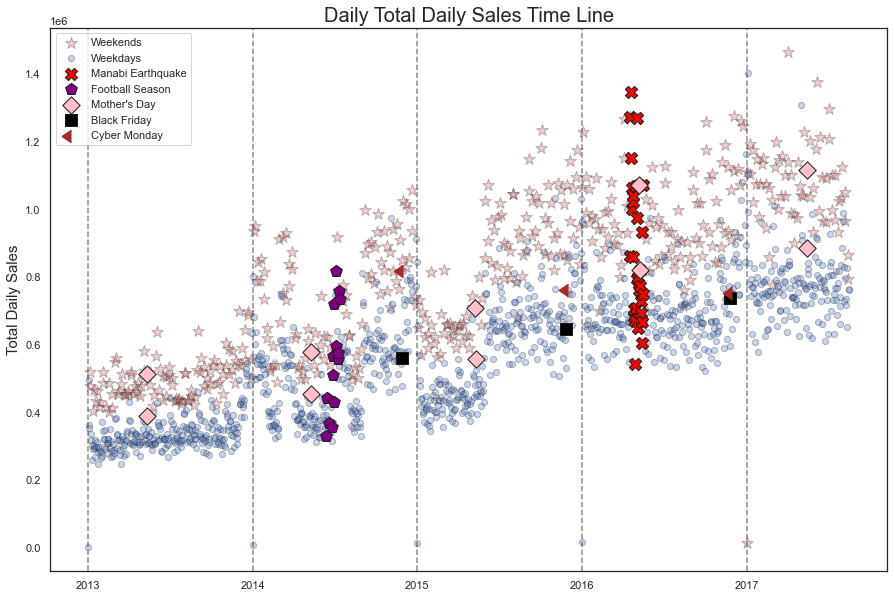

In [41]:
fig, ax = plt.subplots(figsize=(15, 10))

args = dict(x="date",
            y="sales",
            kind="scatter",
            edgecolor="k",
            ax=ax,
            s=150)


# weekends
total_daily_sales[total_daily_sales.index.isin(weekends)].reset_index().\
    plot(**args, marker="*", color="r", label="Weekends", alpha=0.3)

# Weekdays
total_daily_sales[~total_daily_sales.index.isin(weekends)
                  & ~total_daily_sales.index.isin(christmas)].reset_index(
).plot(**args, color="b", label="Weekdays", marker=".", alpha=0.3)


# Earthquake Event
total_daily_sales[total_daily_sales.index.isin(earthquake)].reset_index().\
    plot(**args, color="red", marker="X", label="Manabi Earthquake")

# Footbal Event
total_daily_sales[total_daily_sales.index.isin(futbol)].reset_index().\
    plot(**args, color="purple", marker="p", label="Football Season")

# Mothers day
total_daily_sales[total_daily_sales.index.isin(moms_day)].reset_index().\
    plot(**args, color="Pink", marker="D", label="Mother's Day")

# Black Friday
total_daily_sales[total_daily_sales.index.isin(blk_fri)].reset_index().\
    plot(**args, color="black", marker="s", label="Black Friday")

# Cyber Monday
total_daily_sales[total_daily_sales.index.isin(cyb_mon)].reset_index().\
    plot(**args, color="brown", marker=8, label="Cyber Monday")

ax.set_ylabel("Total Daily Sales")
ax.set_xlabel("")
ax.set_title("Daily Total Daily Sales Time Line")

for newyear in pd.date_range("2013-01-01", "2017-01-01", freq="YS"):
    ax.axvline(newyear, color="k", alpha=0.5, ls="--")

The above plot illustrates the effect of certain events on total daily sales. It seems like the sales is mostly affected by the weekday or weekend rather than the actual event itself. If the event falls on a weekday, the sales remains normal as of any other weekday. Whereas if the event falls on a weekend, the sales is noticeably higher. The only significant sales are seen during the April 2016 Manabi earthquake. Highest sales are seen on weekend during the earthquake event.

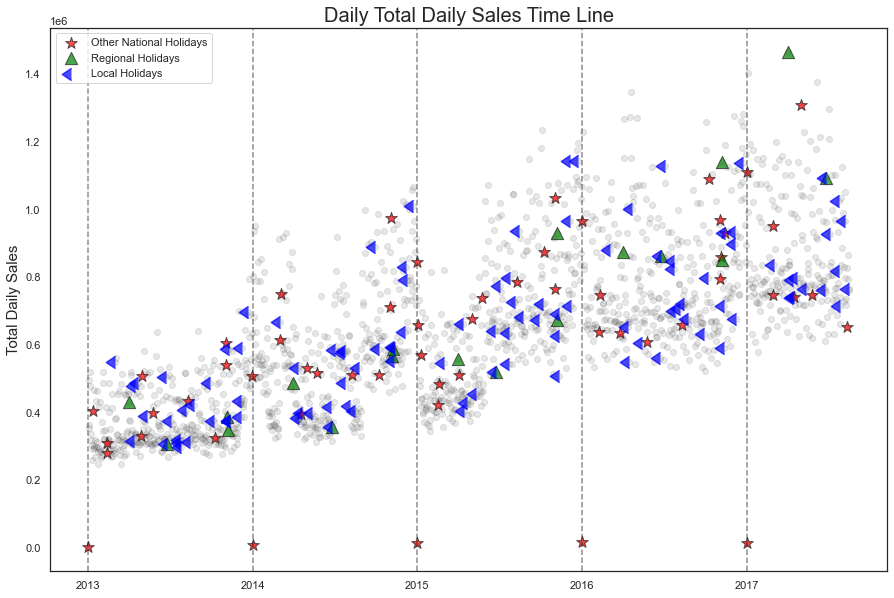

In [42]:
fig, ax = plt.subplots(figsize=(15, 10))

args = dict(x="date",
            y="sales",
            kind="scatter",
            edgecolor="k",
            ax=ax,
            s=150)

total_daily_sales.reset_index().plot(**args, marker=".", alpha=0.1, color="k")

# Other National Holidays
total_daily_sales[total_daily_sales.index.isin(national_holidays_2)].reset_index().\
    plot(**args, color="red", marker="*", label="Other National Holidays", alpha=0.7)

# Other regional Holidays
total_daily_sales[total_daily_sales.index.isin(reg_holidays)].reset_index().\
    plot(**args, color="green", marker="^", label="Regional Holidays", alpha=0.7)

# Other Local Holidays
total_daily_sales[total_daily_sales.index.isin(local_holidays)].reset_index().\
    plot(**args, color="blue", marker=8, label="Local Holidays", alpha=0.7)


ax.set_ylabel("Total Daily Sales")
ax.set_xlabel("")
ax.set_title("Daily Total Daily Sales Time Line")

for newyear in pd.date_range("2013-01-01", "2017-01-01", freq="YS"):
    ax.axvline(newyear, color="k", alpha=0.5, ls="--")

The above plots show remaining holidays. These holidays do not necessarily affect sales (depends on whether the holiday falls on a weekday or weekend).

In [43]:
total_daily_sales = total_daily_sales.to_frame()

#Holidays
total_daily_sales.loc[total_daily_sales.index.isin(christmas), "is_christmas"] = True
total_daily_sales.loc[total_daily_sales.index.isin(transfer_dates), "is_transferred"] = True
total_daily_sales.loc[total_daily_sales.index.isin(national_holidays_2), "is_other_nat_holidays"] = True
total_daily_sales.loc[total_daily_sales.index.isin(reg_holidays), "is_reg_holidays"] = True
total_daily_sales.loc[total_daily_sales.index.isin(local_holidays), "is_local_holidays"] = True

#Events
total_daily_sales.loc[total_daily_sales.index.isin(earthquake), "is_earthquake"] = True
total_daily_sales.loc[total_daily_sales.index.isin(cyb_mon), "is_cybermonday"] = True
total_daily_sales.loc[total_daily_sales.index.isin(blk_fri), "is_blackfriday"] = True
total_daily_sales.loc[total_daily_sales.index.isin(moms_day), "is_momsday"] = True
total_daily_sales.loc[total_daily_sales.index.isin(futbol), "is_football"] = True


# total_daily_sales.loc[total_daily_sales.index.isin(events), "is_event"] = True
# events = earthquake.union(cyb_mon, blk_fri, moms_day, futbol)

total_daily_sales.head()

sales is_christmas is_transferred is_other_nat_holidays  \
date                                                                          
2013-01-01    2511.618999          NaN            NaN                  True   
2013-01-02  496092.417944          NaN            NaN                   NaN   
2013-01-03  361461.231124          NaN            NaN                   NaN   
2013-01-04  354459.677093          NaN            NaN                   NaN   
2013-01-05  477350.121229         True            NaN                   NaN   

           is_reg_holidays is_local_holidays is_earthquake is_cybermonday  \
date                                                                        
2013-01-01             NaN               NaN           NaN            NaN   
2013-01-02             NaN               NaN           NaN            NaN   
2013-01-03             NaN               NaN           NaN            NaN   
2013-01-04             NaN               NaN           NaN            NaN   
2013-01-05             NaN               NaN           NaN            NaN   

           is_blackfriday is_momsday is_football  
date                                              
2013-01-01            NaN        NaN         NaN  
2013-01-02            NaN        NaN         NaN  
2013-01-03            NaN        NaN         NaN  
2013-01-04            NaN        NaN         NaN  
2013-01-05            NaN        NaN         NaN

In [44]:
non_holidays = \
    total_daily_sales[["is_christmas", "is_transferred", "is_other_nat_holidays", "is_reg_holidays",
                       "is_local_holidays", "is_earthquake", "is_cybermonday", "is_blackfriday", 
                       "is_momsday", "is_football"]].isnull().\
        apply(lambda x: all(x), axis = 1)

total_daily_sales.loc[non_holidays, "is_non_holiday"] = True

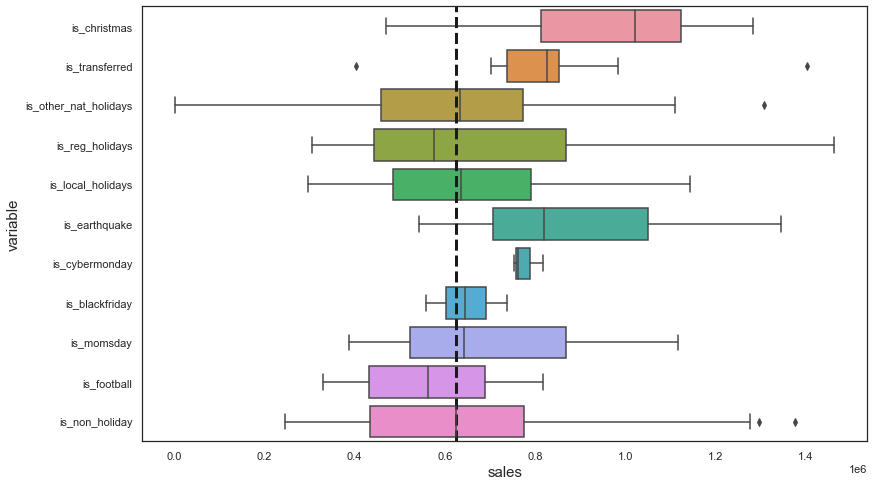

In [45]:
daytype_sales = \
    total_daily_sales.reset_index().melt(id_vars=["date", "sales"]).dropna().drop("value", axis=1)

plt.figure(figsize=(13, 8))

ax = sns.boxplot(x="sales", y="variable", data=daytype_sales, orient="h");

ax.axvline(daytype_sales.query("variable == 'is_non_holiday'")["sales"].median(), 
           color="k", linestyle="--", lw=3);

The above boxplots shows the distribution of sales for each say category. Christmas, tranffered holidays and events drives up sales compared to non-holidays (non holidays includes both weekends and weekdays). Other holidays does not affect sales much. Other holidays are mostly made of holidays celebrated at a local city/state level (not national holidays).

In [46]:
daytype_sales["is_weekend"] = daytype_sales["date"].dt.day_of_week > 4

In [47]:
daytype_sales

date          sales        variable  is_weekend
4     2013-01-05  477350.121229    is_christmas        True
354   2013-12-21  685673.074740    is_christmas        True
355   2013-12-22  696295.146867    is_christmas        True
356   2013-12-23  792865.284427    is_christmas       False
357   2013-12-24  620663.290732    is_christmas       False
...          ...            ...             ...         ...
18516 2017-08-08  717766.349106  is_non_holiday       False
18517 2017-08-09  734139.674010  is_non_holiday       False
18520 2017-08-12  792630.535079  is_non_holiday        True
18521 2017-08-13  865639.677471  is_non_holiday        True
18522 2017-08-14  760922.406081  is_non_holiday       False

[1703 rows x 4 columns]

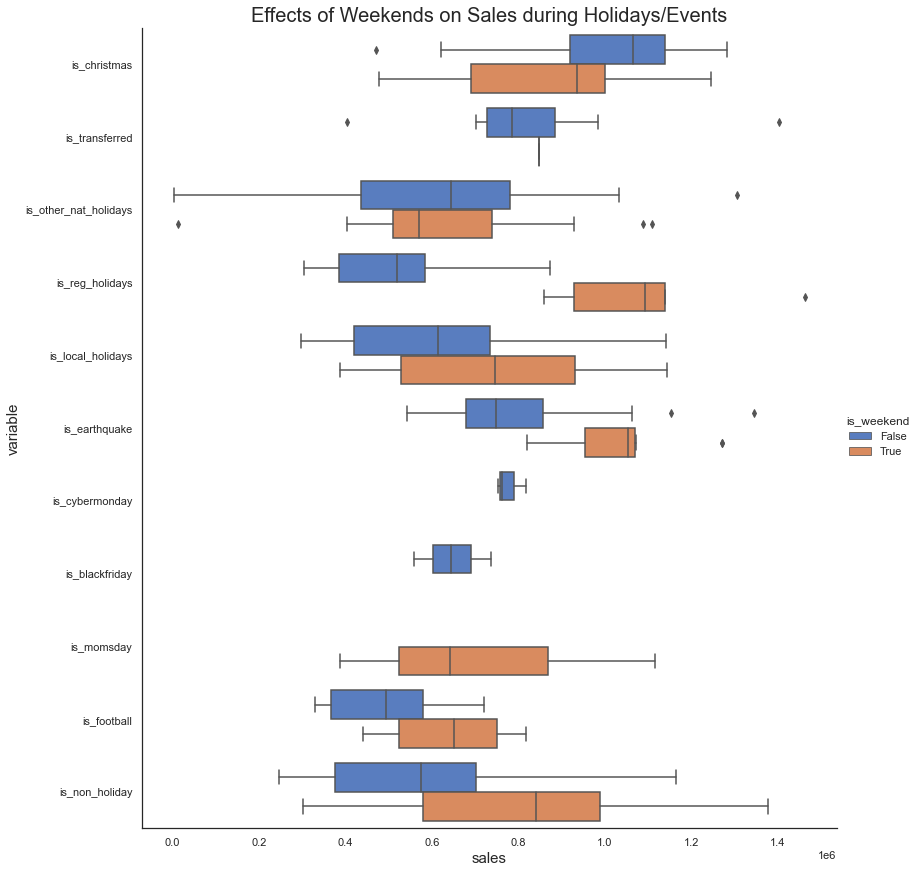

In [48]:
sns.catplot(
    x="sales",
    y="variable",
    data=daytype_sales, 
    orient="h",
    kind="box",
    hue="is_weekend",
    aspect=1,
    height=12
);

plt.title("Effects of Weekends on Sales during Holidays/Events");

The above plots shows the how sales differ across all holidays/events during weekdays and weekends.

* During Christmas and other national holidays, median sales are higher during weekdays.
* For the rest of the holidays/events, sales are higher on weekends.
* Cyber monday and black friday always falls on weekdays, whereas moms day always falls on weekend.

# Store group types

In [49]:
train_df_storetype = train_df.groupby(["date", "type"], as_index=False)["sales"].sum()
train_df_storetype

date type          sales
0    2013-01-01    A       0.000000
1    2013-01-01    B       0.000000
2    2013-01-01    C       0.000000
3    2013-01-01    D    2511.618999
4    2013-01-01    E       0.000000
...         ...  ...            ...
8415 2017-08-15    A  220464.355977
8416 2017-08-15    B  122307.633986
8417 2017-08-15    C  141869.223000
8418 2017-08-15    D  215126.683976
8419 2017-08-15    E   62894.039000

[8420 rows x 3 columns]

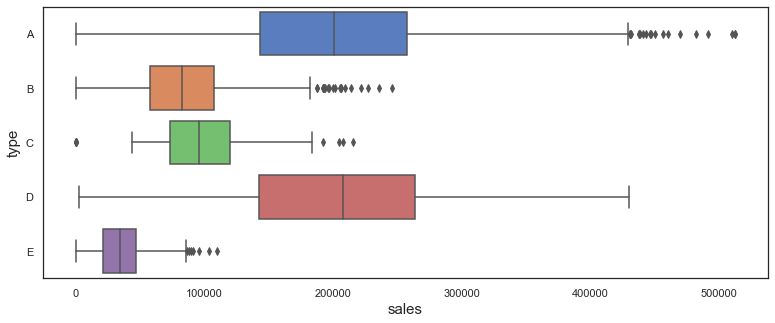

In [50]:
fig, ax = plt.subplots(figsize=(13, 5))

sns.boxplot(x="sales", y="type", data=train_df_storetype, orient="h");

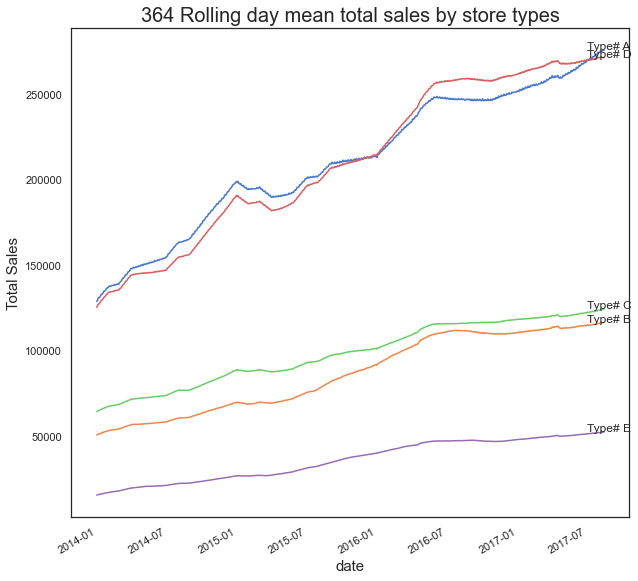

In [51]:
fig, ax = plt.subplots(figsize=(10, 10))
roll_period = 365

for store in train_df_storetype["type"].unique():

    roll_mean = \
        train_df_storetype.query(f"type == '{store}'").set_index("date").\
        rolling(roll_period)["sales"].mean().to_frame(f"{store}")

    roll_mean.plot(ax=ax, legend=None)

    xy_coord = roll_mean.reset_index().iloc[-1, :].values

    ax.annotate(text=f"Type# {store}",
                xy=xy_coord,
                xytext=xy_coord + np.array([-pd.Timedelta("45 days"), 100]))

plt.ylabel("Total Sales")
plt.title("364 Rolling day mean total sales by store types");

Not sure whether the store type will be a useful feature as it depends on the store number itself.

# Promotion

In [52]:
train_df["is_promotion"] = np.where(train_df["onpromotion"].eq(0), 0, 1)

Mean: is_promotion
0     158.246681
1    1137.693730
Name: sales, dtype: float64

Median: is_promotion
0      3.0
1    373.0
Name: sales, dtype: float64


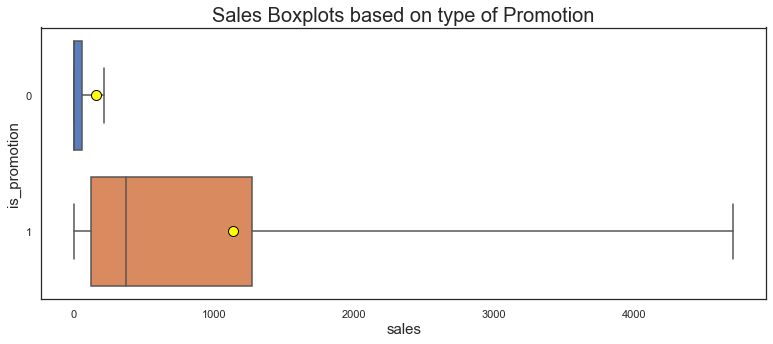

In [53]:
print(f'Mean: {train_df.groupby("is_promotion")["sales"].mean()}')
print()
print(f'Median: {train_df.groupby("is_promotion")["sales"].median()}')

fig, ax = plt.subplots(figsize=(13, 5))

sns.boxplot(x="sales",
            y="is_promotion",
            data=train_df,
            orient="h",
            whis=3,
            showfliers=False,
            showmeans=True,
            meanprops={
                "marker": "o",
                "markerfacecolor": "yellow",
                "markeredgecolor": "black",
                "markersize": "10"
            },
            ax=ax)

# sns.stripplot(x="sales", y="is_promotion", data=train_df, orient="h", ax=ax, color="k", 
#               alpha=0.1)

ax.set_title("Sales Boxplots based on type of Promotion");

Sales is affected by promotion

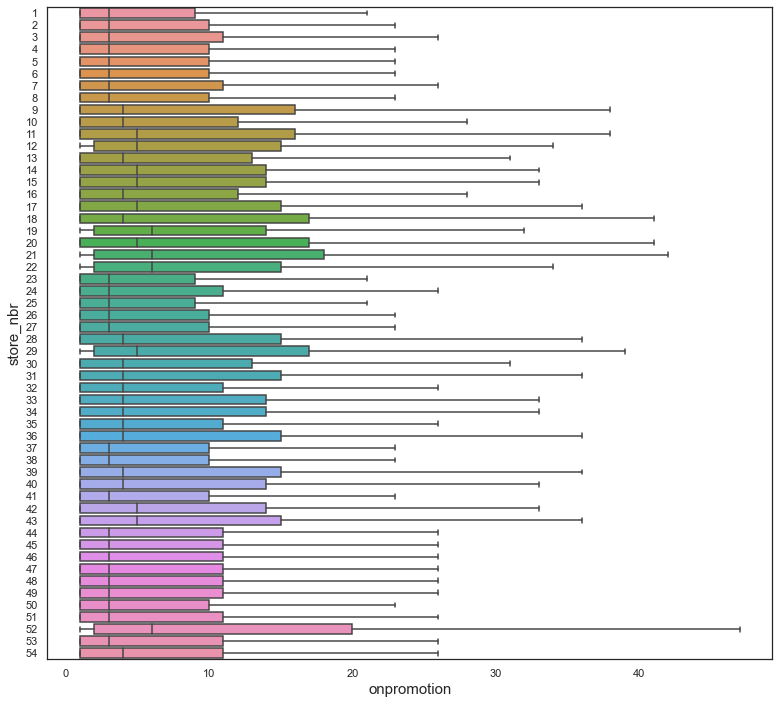

In [54]:
plt.figure(figsize=(13, 12))

sns.boxplot(x="onpromotion",
            y="store_nbr",
            data=train_df.query("is_promotion == 1"),
            orient="h",
            showfliers=False);

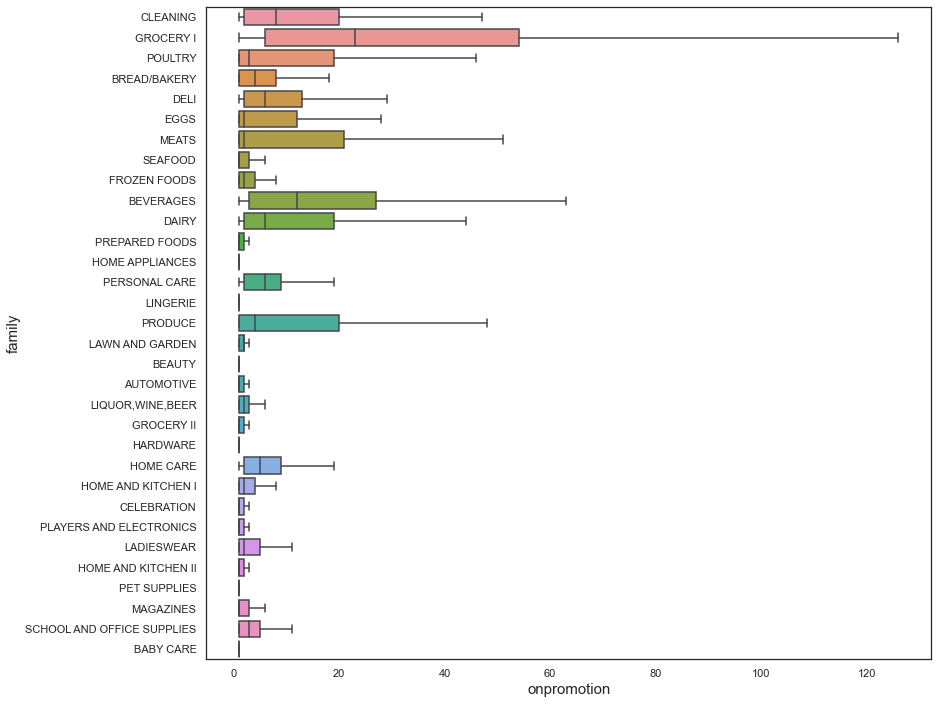

In [55]:
plt.figure(figsize=(13, 12))

sns.boxplot(x="onpromotion",
            y="family",
            data=train_df.query("is_promotion == 1"),
            orient="h",
            showfliers=False);

The promotion differs by both stores and the family. Most of the promotions depends on certain types of products, mainly GROCERY I, BEVERAGES, CLEANING, PRODUCE, DAIRY etc.

### Promotion by day, month, etc

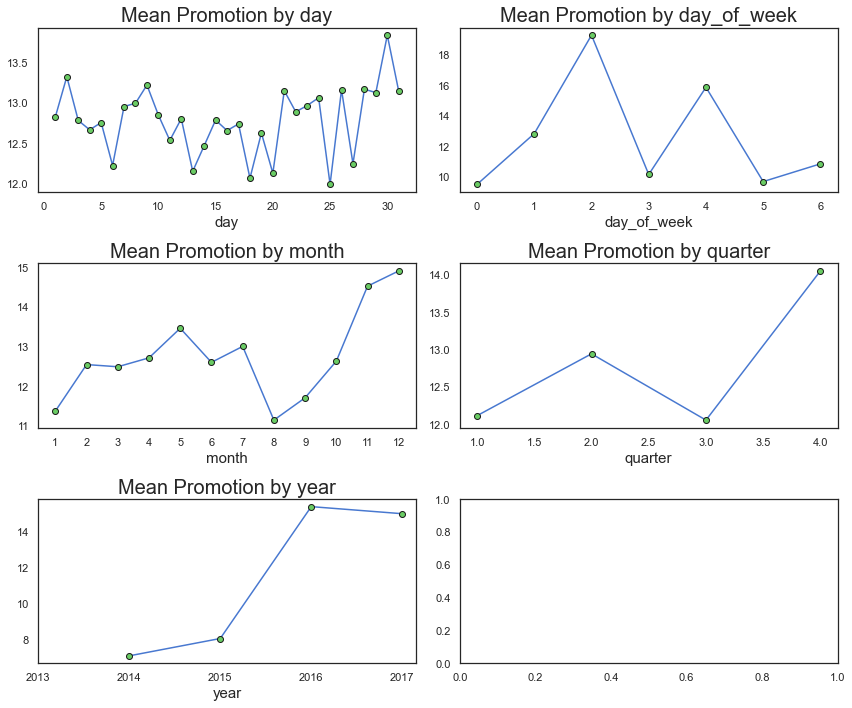

In [56]:
fig, axes = plt.subplots(3, 2, tight_layout=True, figsize=(12, 10))

for col, ax in zip(["day", "day_of_week", "month", "quarter", "year"], axes.flatten()):

    train_df.query("is_promotion==1").groupby(col)["onpromotion"].mean().\
        plot(ax=ax, marker="o", mfc="g", mec="k")
    
    ax.set_title(f"Mean Promotion by {col}")

    if col in ["year", "month"]:
        ax.set_xticks(train_df.groupby(col)["onpromotion"].mean().index)

* **day**: There is no noticable seasonal pattern during days within a month. Probably there are higher promotions during month-end.
* **month**: Promotions are lowest during Jan and Aug. Promotions are highest on Dec and Nov.
* **year**: There were no promotions during 2013. From 2014 pnwards, the mean promotions has been increasing significantly.
* **week**: In a week, Promotons are lowest on monday, followed by thursday and weekends. Promotions are highest on Wednesday and Friday.

# Sales vs Promotion

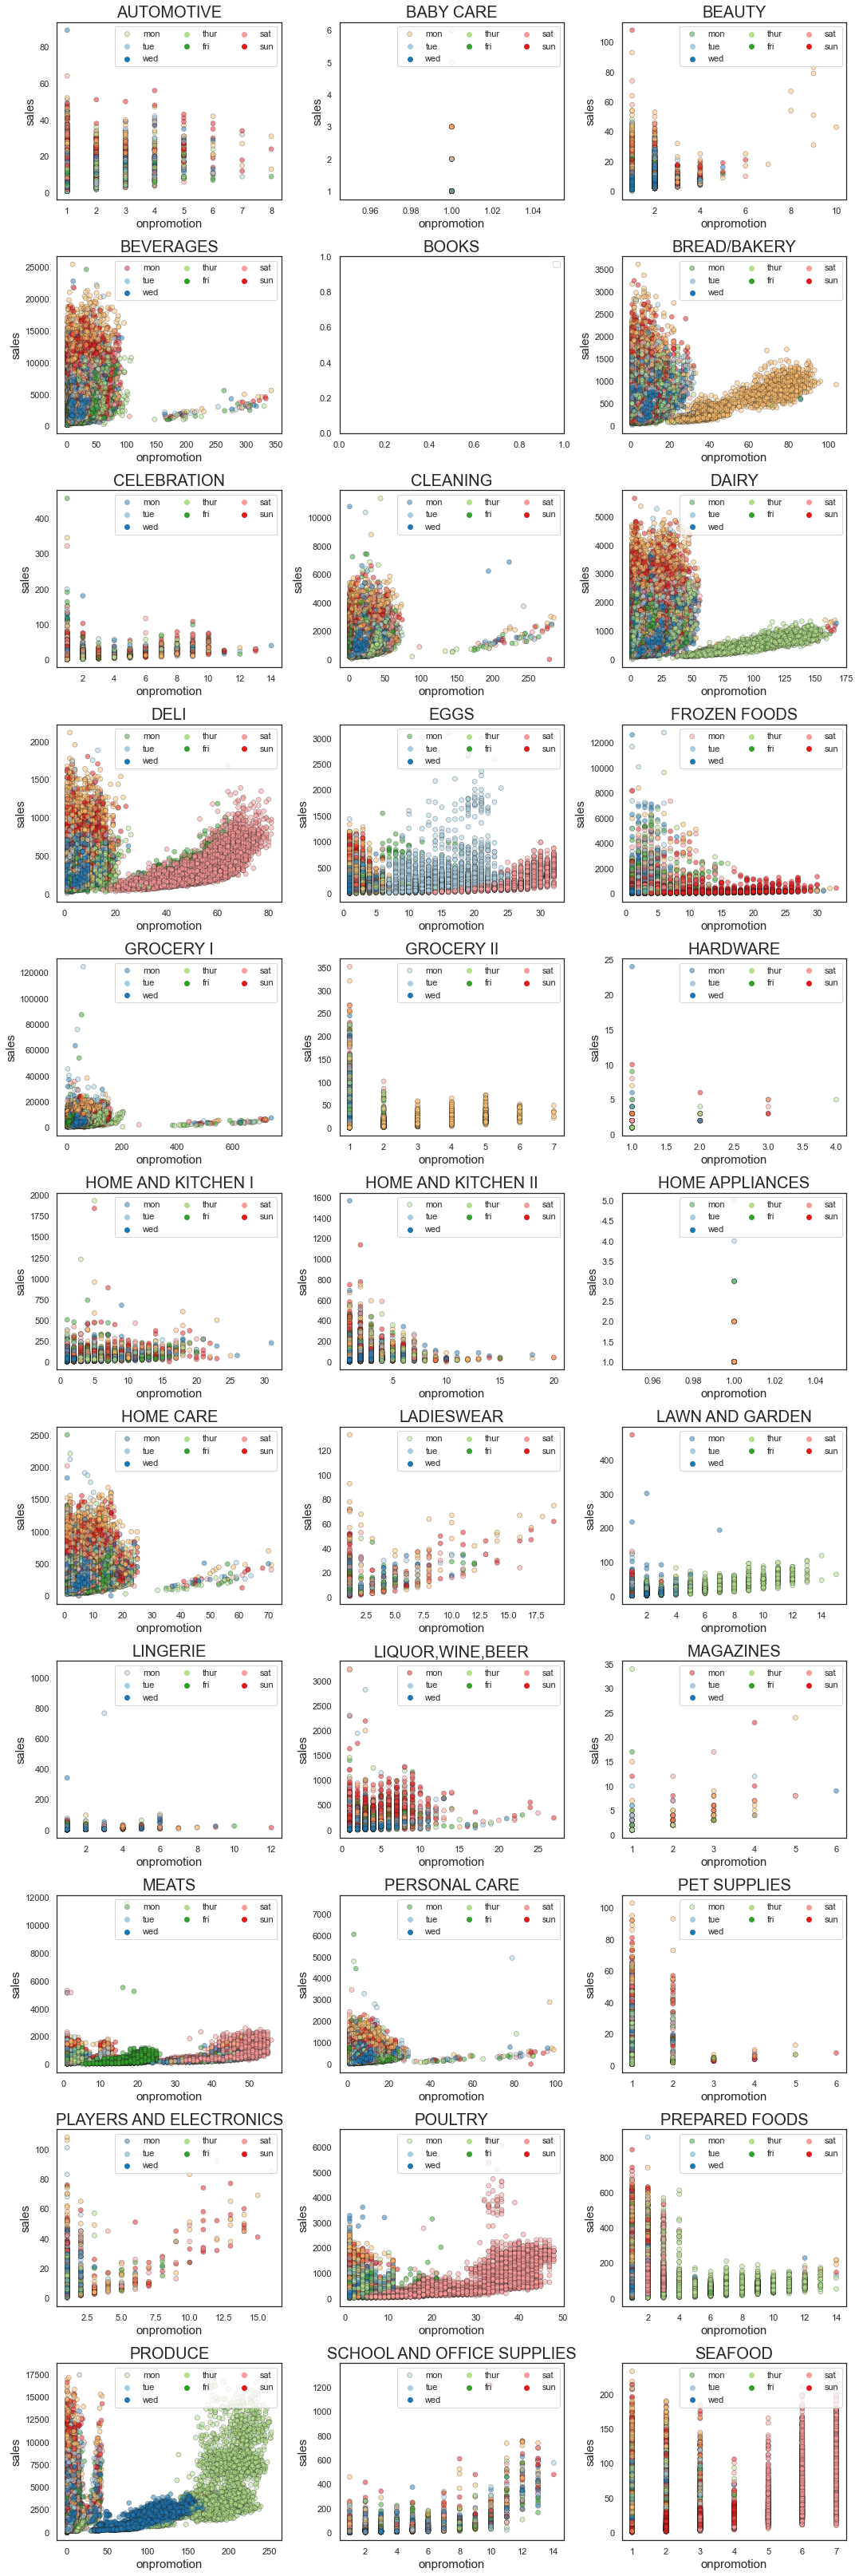

In [57]:
fig, axes = plt.subplots(11, 3, tight_layout=True, figsize=(15, 45))

for prd, ax in zip(train_df["family"].unique(), axes.flatten()):

    sns.scatterplot(
        x="onpromotion",
        y="sales",
        data=train_df.query(f"is_promotion == 1 and family == '{prd}'"),
        edgecolor="k",
        alpha=0.5,
        hue="day_of_week",
        ax=ax,
        palette="Paired",
    )

    ax.set_title(prd)
    ax.legend(labels=["mon", "tue", "wed", "thur", "fri", "sat", "sun"],
              loc="upper right",
              ncol=3)

The above illustrates scatter plot between promotions and sales for every family. It is clear that certain days have higher promotions. Its is clear how does the promotions drive up sales. Perhaps certain products within the family influences the sales.

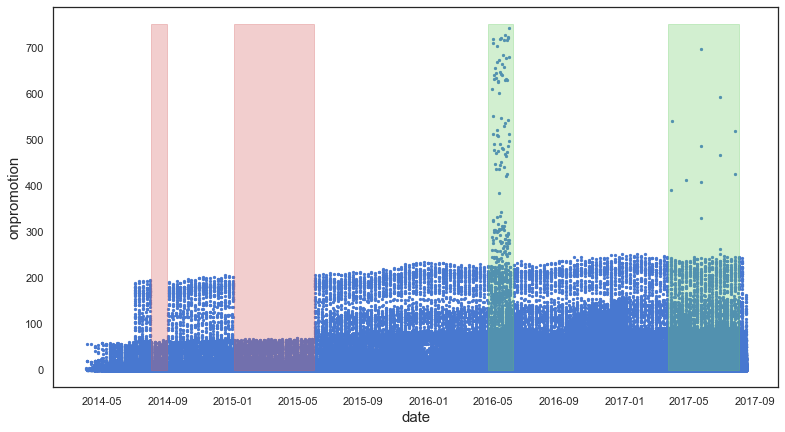

In [58]:
# Daily promotions time series

train_df.query("onpromotion > 0").\
    plot(x="date", y="onpromotion", kind="scatter",
         color="b", figsize=(13, 7), marker=".", legend=None)

plt.fill_between(
    (pd.to_datetime("2016-04-20"), pd.to_datetime("2016-06-7")), 
    750,
    alpha=0.3, 
    color="g"
)

plt.fill_between(
    (pd.to_datetime("2017-03-24"), pd.to_datetime("2017-08-02")), 
    750,
    alpha=0.3, 
    color="g"
)

plt.fill_between(
    (pd.to_datetime("2015-01-03"), pd.to_datetime("2015-06-01")), 
    750,
    alpha=0.3, 
    color="r"
)

plt.fill_between(
    (pd.to_datetime("2014-08-01"), pd.to_datetime("2014-08-31")), 
    750,
    alpha=0.3, 
    color="r"
);

The above plot shows the daily time series promotions. Promotions begins after 2014. There are 4 interesting periods where promotions very low (regions shaded in red) and where promotions very very high (regions shaded in green).

In the next sections, I will analyze these shaded regions.

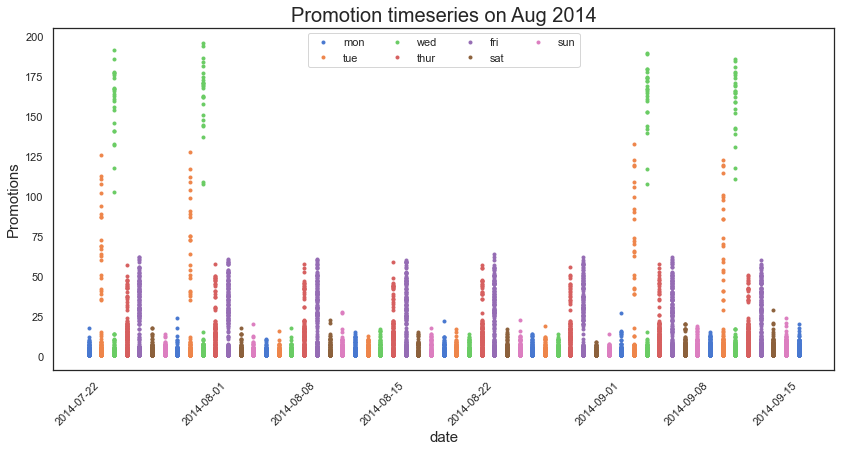

In [59]:
fig, ax = plt.subplots(figsize=(14, 7))

for i in range(0, 7, 1):
    train_df.query(f"onpromotion>0 and date>='2014-07-21' and date<='2014-09-15' and day_of_week=={i}").\
    plot(x="date", y="onpromotion", linestyle="", marker=".", rot=45, ax=ax, label=i);
    
ax.legend(labels=["mon", "tue", "wed", "thur", "fri", "sat", "sun"], ncol=4);

ax.set_title("Promotion timeseries on Aug 2014")
ax.set_ylabel("Promotions");

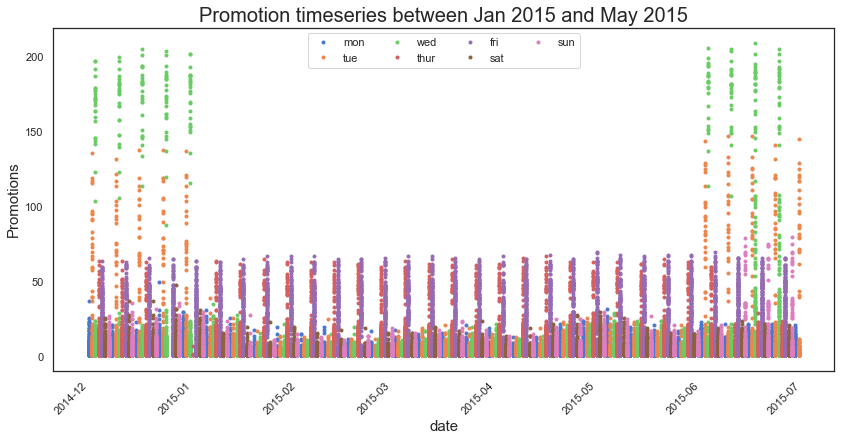

In [60]:
fig, ax = plt.subplots(figsize=(14, 7))

for i in range(0, 7, 1):
    train_df.query(f"onpromotion>0 and date>='2014-12-01' and date<='2015-06-30' and day_of_week=={i}").\
        plot(x="date", y="onpromotion", linestyle="", marker=".", rot=45, ax=ax, label=i);
    
ax.legend(labels=["mon", "tue", "wed", "thur", "fri", "sat", "sun"], ncol=4);

ax.set_title("Promotion timeseries between Jan 2015 and May 2015")
ax.set_ylabel("Promotions");

From the above 2 plots, it is clear that during those 2 periods, the promotions offered during Tuesdays and Wednesdays were much lower than what was usually offered on these days.

Most likely, the **sales were much lower too during these 2 periods.**

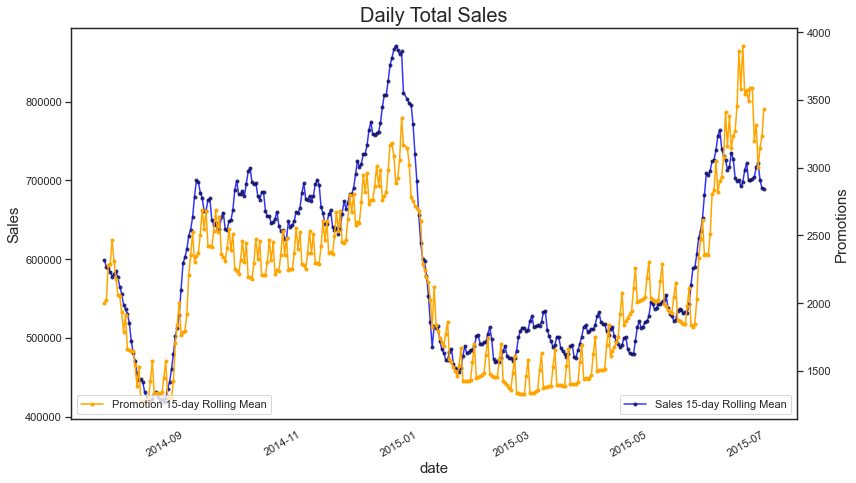

In [61]:
rolling_period=15

fig, ax1 = plt.subplots(figsize=(13, 8))
ax2 = ax1.twinx()

#Sales
total_daily_sales.query("date>='2014-07-21' and date<='2015-06-30'").\
    rolling(rolling_period, center=True, min_periods=1).mean().\
        plot(y="sales", marker=".", alpha=0.8, mec='k', ax=ax1, color="blue")

#Promotion
train_df.groupby("date")["onpromotion"].sum().to_frame().\
    query(f"onpromotion>0 and date>='2014-07-21' and date<='2015-06-30'").\
        rolling(rolling_period, center=True, min_periods=1).mean().\
            plot(y="onpromotion", marker=".", rot=45, ax=ax2, color="orange", legend=None);

ax1.legend(labels=[f"Sales {rolling_period}-day Rolling Mean"], loc="lower right")
ax2.legend(labels=[f"Promotion {rolling_period}-day Rolling Mean"], loc="lower left")

ax1.set_title("Daily Total Sales")
ax1.set_ylabel("Sales")
ax2.set_ylabel("Promotions");

The above plot compares the rolling mean time series of both sales and promotions. It is clear that Sales depends on the promotions. When promotions are low, sales drop too. 

### Promotions between April 2016 and May 2016 - Manabi Earthquke event

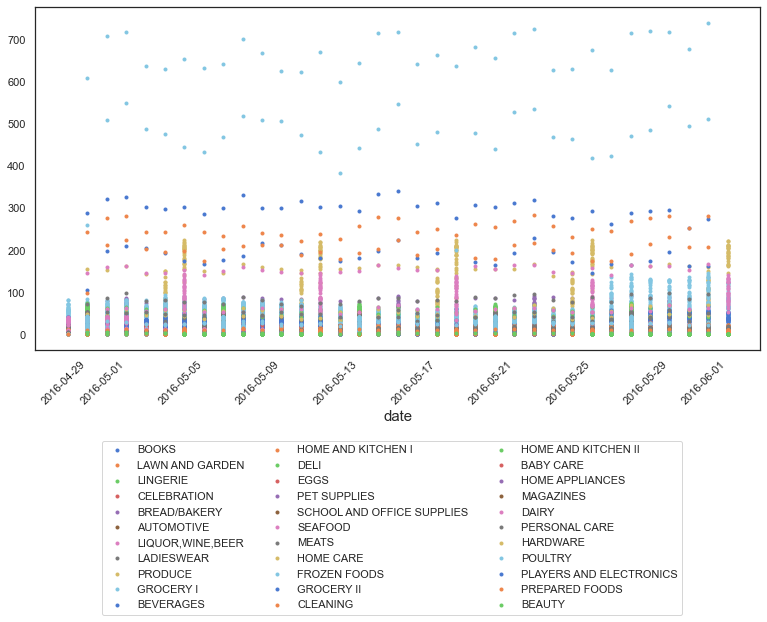

In [62]:
fig, ax = plt.subplots(figsize=(13, 7))

for prd in set(train_df["family"]):

    train_df.query(
        f"onpromotion > 0 and date >= '2016-04-28' and date <= '2016-06-01' and family == '{prd}'"
    ).plot(x="date",
           y="onpromotion",
           linestyle="",
           marker=".",
           legend=None,
           rot=45,
           ax=ax,
           label=f"{prd}")

plt.legend(ncol=3, bbox_to_anchor=(0.9, -0.25));

In [63]:
train_df.query("onpromotion > 0 and date >= '2016-04-28' and date <= '2016-06-01'").\
    groupby(["store_nbr", "family"], as_index=False)["onpromotion"].mean().\
        sort_values("onpromotion", ascending=False).head(8)

store_nbr     family  onpromotion
1086         53  GROCERY I   635.171429
1118         54  GROCERY I   440.457143
1078         53  BEVERAGES   285.485714
1081         53   CLEANING   241.314286
1113         54   CLEANING   183.628571
1110         54  BEVERAGES   170.485714
1104         53    PRODUCE   157.911765
1082         53      DAIRY   146.657143

In [64]:
store_df.query("store_nbr in (53, 54)")

store_nbr       city   state type  cluster
52         53      Manta  Manabi    D       13
53         54  El Carmen  Manabi    C        3

On 16 April 2018, an **earthquake** struck the state of Manabi. The main stores located in Manabi are 53 & 54. Hence both of these stores were giving high promotions for a whole month after the disaster for certain family products such as GROCERY I, BEVERAGES, CLEANING, PRODUCE, DAIRY, etc.

In [65]:
store_df.query("state=='Manabi'")
#There are 3 stores in Manabi. What about store 52?

store_nbr       city   state type  cluster
51         52      Manta  Manabi    A       11
52         53      Manta  Manabi    D       13
53         54  El Carmen  Manabi    C        3

In [66]:
train_df.query("store_nbr == 52 and date >= '2016-04-16' and date <= '2016-06-01'")["onpromotion"].sum()

0

Store 52, which is also located in Manabi, gave no promotions during this time period.

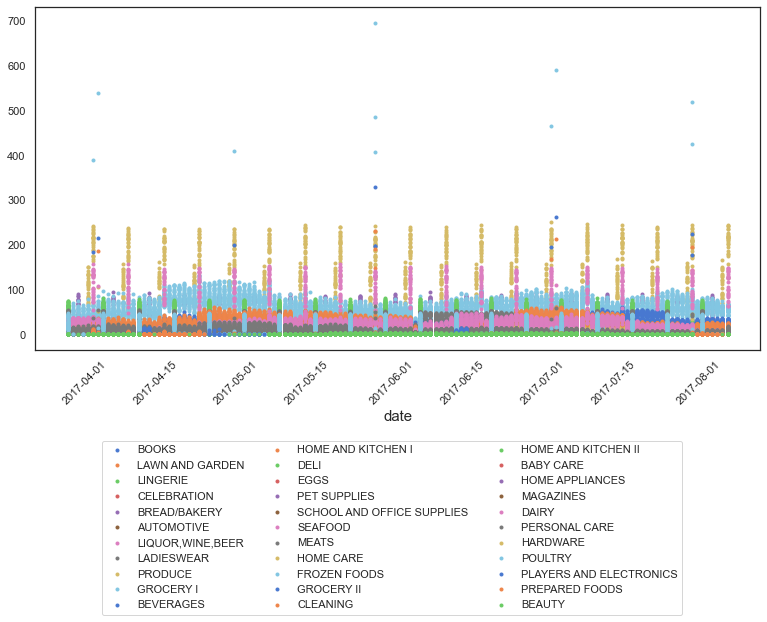

In [67]:
fig, ax = plt.subplots(figsize=(13, 7))

for prd in set(train_df["family"]):

    train_df.query(
        f"onpromotion > 0 and date >= '2017-03-24' and date <= '2017-08-02' and family == '{prd}'"
    ).plot(x="date",
           y="onpromotion",
           linestyle="",
           marker=".",
           legend=None,
           rot=45,
           ax=ax,
           label=f"{prd}")

plt.legend(ncol=3, bbox_to_anchor=(0.9, -0.25));

In [68]:
train_df.query("onpromotion > 280 and date >= '2017-03-24' and date <= '2017-08-02'").\
    sort_values("date")[["date", "store_nbr", "family", "onpromotion", "state", "city"]]

date  store_nbr     family  onpromotion  \
2752344 2017-03-29         35  GROCERY I          391   
2754060 2017-03-30         33  GROCERY I          539   
2802240 2017-04-26         35  GROCERY I          411   
2851443 2017-05-24         16  GROCERY I          486   
2852136 2017-05-24         35  GROCERY I          407   
2852160 2017-05-24         36  BEVERAGES          330   
2852169 2017-05-24         36  GROCERY I          697   
2913813 2017-06-28         16  GROCERY I          467   
2916222 2017-06-29         33  GROCERY I          591   
2963709 2017-07-26         16  GROCERY I          519   
2964402 2017-07-26         35  GROCERY I          425   

                                  state           city  
2752344                          Guayas         Playas  
2754060                        Los Rios        Quevedo  
2802240                          Guayas         Playas  
2851443  Santo Domingo de los Tsachilas  Santo Domingo  
2852136                          Guayas         Playas  
2852160                          Guayas       Libertad  
2852169                          Guayas       Libertad  
2913813  Santo Domingo de los Tsachilas  Santo Domingo  
2916222                        Los Rios        Quevedo  
2963709  Santo Domingo de los Tsachilas  Santo Domingo  
2964402                          Guayas         Playas

Not clear why these stores were giving high promotions for certain products.

# Total Sales vs Total Promotions

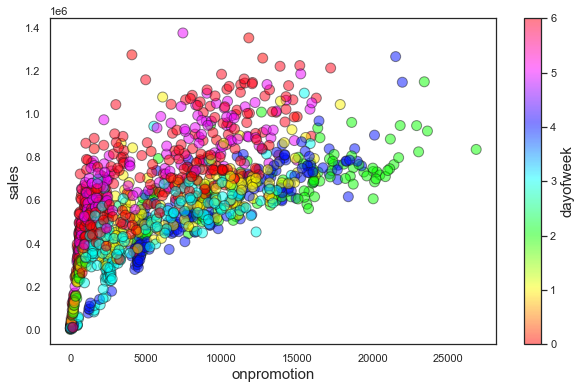

In [69]:
total_sales_promot = \
    train_df.query("onpromotion != 0").groupby(
        "date")[["sales", "onpromotion"]].sum()

total_sales_promot["dayofweek"] = total_sales_promot.index.dayofweek

fig, ax = plt.subplots(figsize=(10, 6))

total_sales_promot.plot(x="onpromotion",
                        y="sales",
                        kind="scatter",
                        c="dayofweek",
                        cmap="hsv",
                        edgecolor="k",
                        marker="o",
                        alpha=0.5,
                        s=100,
                        ax=ax)

ax.set_xlabel("onpromotion");

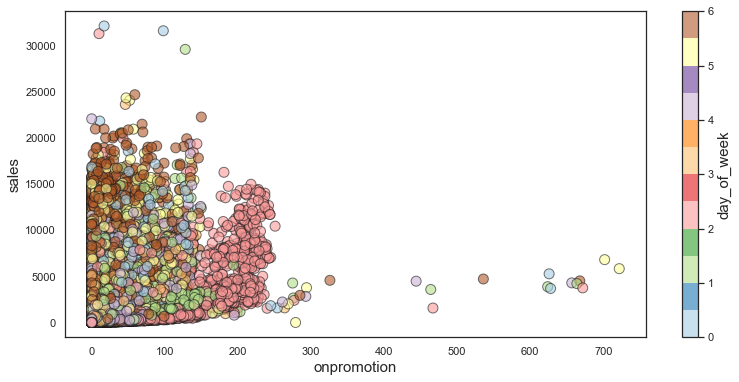

In [70]:
fig, ax = plt.subplots(figsize=(13, 6))

train_df.sample(frac=0.2).plot(y="sales",
              x="onpromotion",
              kind="scatter",
              s=100,
              alpha=0.6,
              c="day_of_week",
              cmap="Paired",
              edgecolor="k",
              ax=ax);

In [71]:
train_df["log_sales"] = np.log(train_df["sales"] + 0.1)
train_df["log_onpromotion"] = np.log(train_df["onpromotion"] + 0.1)

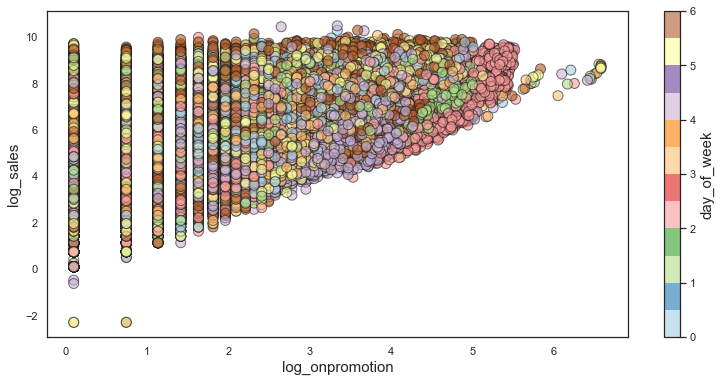

In [72]:
fig, ax = plt.subplots(figsize=(13, 6))

train_df.query("is_promotion == 1").sample(frac=0.2).plot(y="log_sales",
                                         x="log_onpromotion",
                                         kind="scatter",
                                         s=100,
                                         alpha=0.6,
                                         c="day_of_week",
                                         cmap="Paired",
                                         edgecolor="k",
                                         ax=ax);

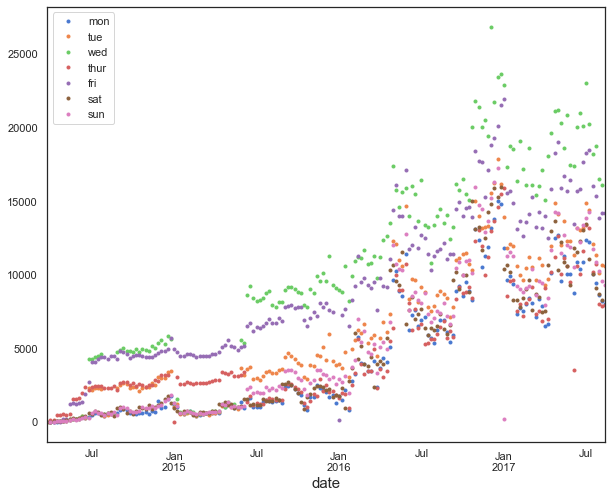

In [73]:
fig, ax = plt.subplots(figsize=(10, 8))

for i in np.arange(7):

    total_sales_promot.query(f"dayofweek == {i}").\
        plot(y="onpromotion", linestyle="", marker=".", ax=ax, label=f"{i}")

ax.legend(labels=["mon", "tue", "wed", "thur", "fri", "sat", "sun"]);

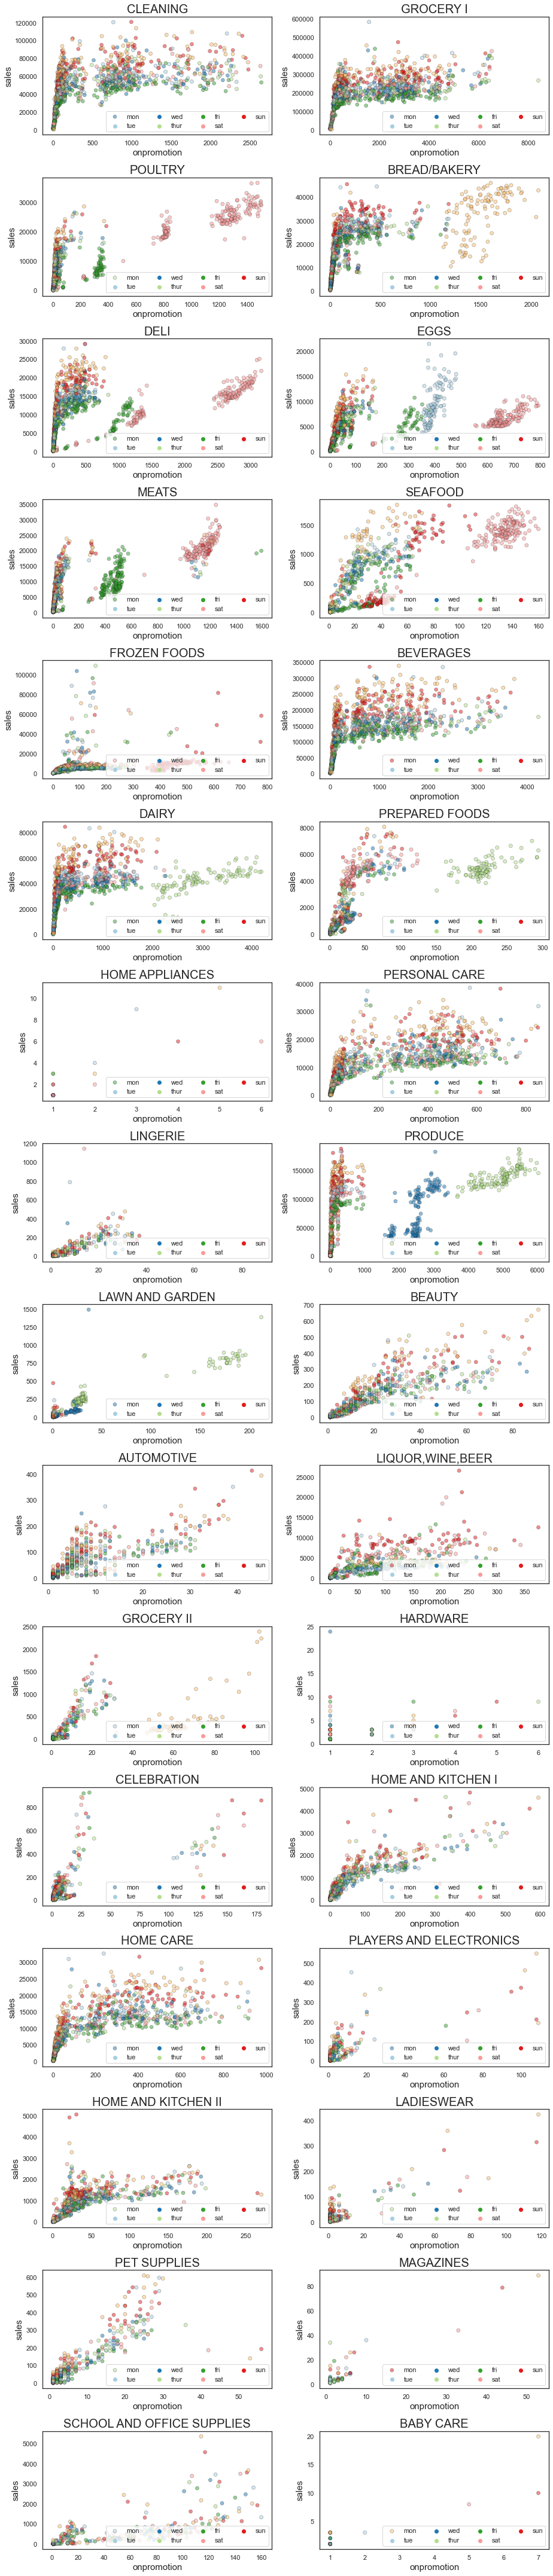

In [74]:
tot_sales_promot_family = \
    train_df.query("onpromotion != 0").\
    groupby(["date", "family"], as_index=False)[["sales", "onpromotion"]].sum()

tot_sales_promot_family["dayofweek"] = tot_sales_promot_family[
    "date"].dt.dayofweek

fig, axes = plt.subplots(16, 2, tight_layout=True, figsize=(13, 60))

for prd, ax in zip(tot_sales_promot_family["family"].unique(), axes.flatten()):

    sns.scatterplot(
        x="onpromotion",
        y="sales",
        data=tot_sales_promot_family.query(f"family == '{prd}'"),
        edgecolor="k",
        alpha=0.5,
        hue="dayofweek",
        ax=ax,
        palette="Paired",
    )

    ax.set_title(prd)
    ax.legend(labels=["mon", "tue", "wed", "thur", "fri", "sat", "sun"],
              loc="lower right",
              ncol=4)

Overall, when aggregating by taking the sum of daily sales and promotions, we can see both promotions and the day the promotions was offered influences the sales of certain products.

# Sales vs oil price

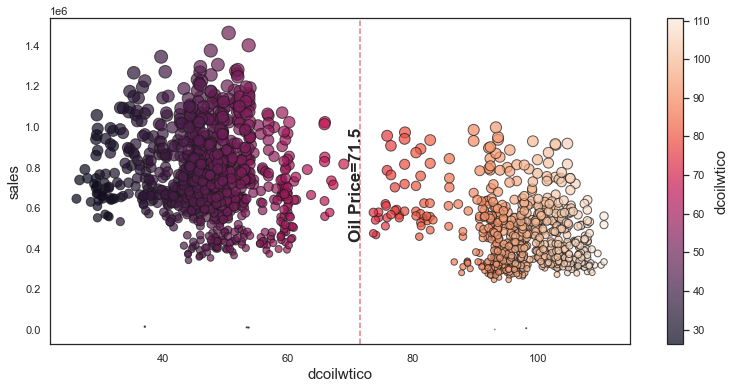

In [75]:
fig, ax = plt.subplots(figsize=(13, 6))

agg_df = train_df.groupby("date")[["sales", "onpromotion"]].sum().\
    join(oil_df_imputed).fillna(method="ffill")

size = agg_df["sales"] / 8000

agg_df.plot(x="dcoilwtico",
            y="sales",
            kind="scatter",
            edgecolor="k",
            alpha=0.7,
            c="dcoilwtico",
            ax=ax,
            s=size)

ax.axvline(71.5, linestyle="--", color="r", alpha=0.8);
ax.text(x=69.8, y=0.45*10**6, s="Oil Price=71.5", rotation=90, fontsize="x-large", fontweight="bold");

The above plot is a scatter plot between total daily sales and daily oil prices. There seems to be **2 clusters** within the plot - **One with a higher concentration of high sales and lower oil prices, the other cluster with lower concentraion of lowsales and higher oil price**.

In [76]:
#Median Sales when Oil price lower than 71.5
agg_df.query("dcoilwtico < 71.5")["sales"].median()

735733.2142477001

In [77]:
#Median Sales when Oil price higher than 71.5
agg_df.query("dcoilwtico >= 71.5")["sales"].median()

430411.991233

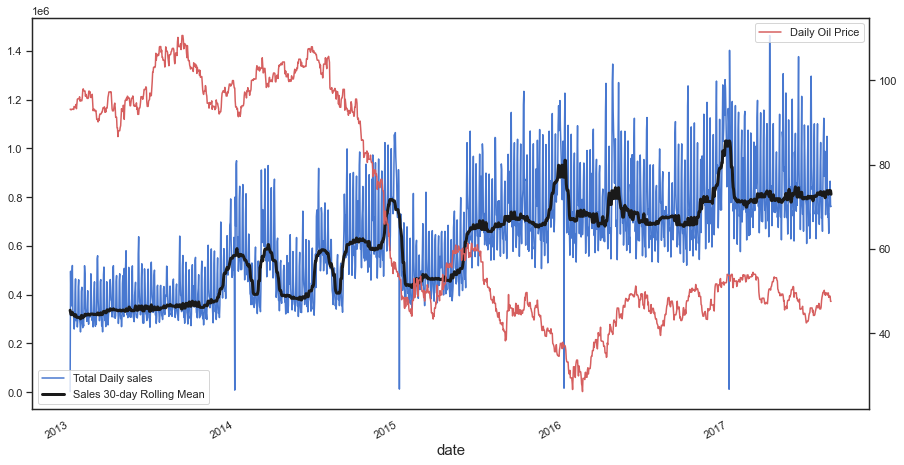

In [78]:
fig, ax1 = plt.subplots(figsize=(15, 8))
ax2 = ax1.twinx()

agg_df.plot(y="sales", ax=ax1, color="b", label="Total Daily sales")

agg_df.rolling(30, center=True, min_periods=7).median().\
    plot(y="sales", ax=ax1, color="k", label="Sales 30-day Rolling Mean", lw=3,)

agg_df.plot(y="dcoilwtico", ax=ax2, color="r", label="Daily Oil Price");

ax1.legend(loc="lower left");

It is **not apparent whether oil prices affect sales**. Although there is a sharp decrease in oil price, there is no dramatic increase of sales as a result.

The increases in sales during the period where oil prices are lower could be perhaps attributed to increasing trend of sales. More analysis needs to be done in order to establish a causal relation between oil price and sales.

In the next section, I will use statistical tests to determine whether both `onpromotion` and `dcoilwtico` variables influences `sales` variable.

### Decomposing  Total Daily Sales, Oil Price and Promotions to make them stationary.

One of the prerequisites for all of the tests is to ensure the time series are stationary - i.e, there are no trend or seasonal components. For both `sales` and `onpromotion` variables, I will use [MSTL](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.MSTL.html#statsmodels.tsa.seasonal.MSTL) (Multiple Seasonal-Trend decomposition using LOESS) method to extract trend, seasonal (#Weekly, monthly, quaterly and yearly seasonality) and residual components. Since the residual component is free from trend and seasonality, this component will be used for the tests. 

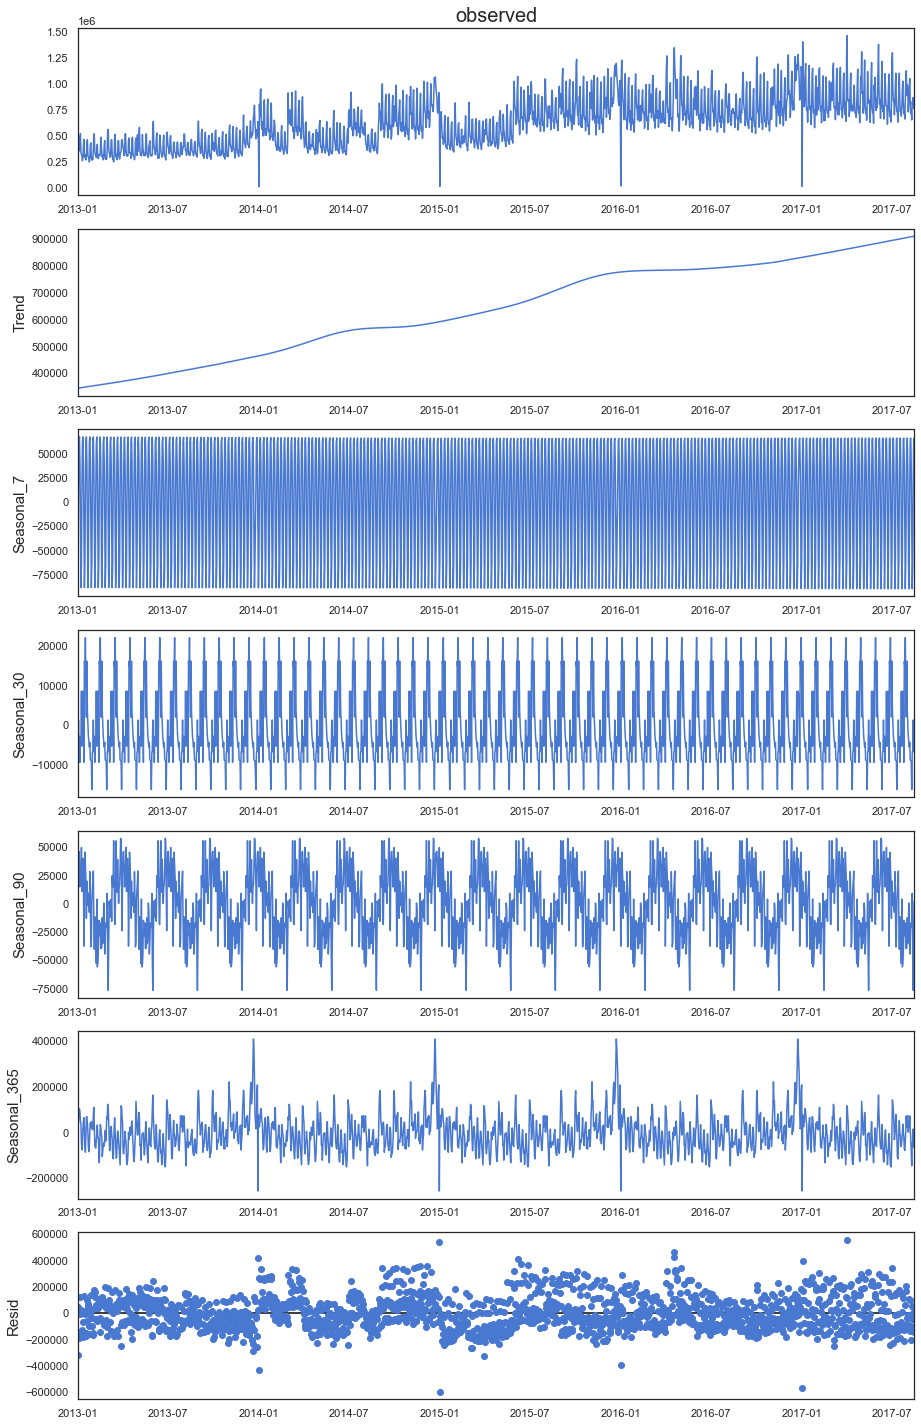

In [79]:
#Decomposing Sales
mstl = MSTL(agg_df["sales"], 
            periods=(7, 30, 90, 365), #Weekly, monthly, quaterly and yearly seasonality
            windows=[1001, 1001, 1001, 1001],
            stl_kwargs={
                "seasonal_deg":0, # Means the seasonal smoother is fit with a moving average.
               }
           )

res=mstl.fit()

plt.rc("figure", figsize=(13, 20))
plt.rc("font", size=13)
fig = res.plot()

In [80]:
agg_df["sales_resid"] = res.resid

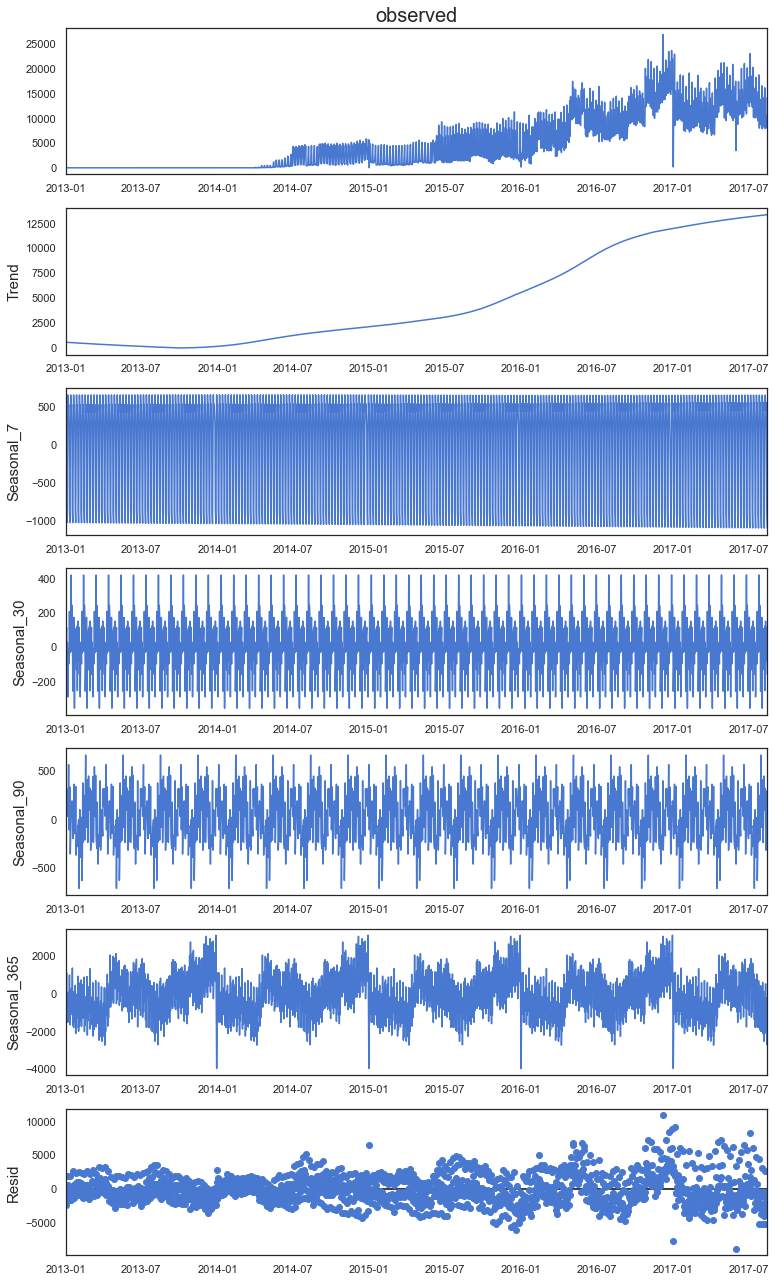

In [81]:
#Decomposing onpromotion
mstl = MSTL(agg_df["onpromotion"], 
            periods=(7, 30, 90, 365), #Weekly, monthly, quaterly and yearly seasonality
            windows=[1001, 1001, 1001, 1001],
            stl_kwargs={
                "seasonal_deg":0, # Means the seasonal smoother is fit with a moving average.
               }
           )

res=mstl.fit()

plt.rc("figure", figsize=(11, 18))
plt.rc("font", size=13)
fig = res.plot()

In [82]:
agg_df["promotion_resid"] = res.resid

for oil price variable, since there is no discernible trend or seasonal component, I will simply difference this variable to make it stationary. 

In [83]:
agg_df["oilprice_diff"] = agg_df["dcoilwtico"].diff()

In order to ensure all time series are stationary,  [Augmented Dickey-Fuller](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) test will be used. 

"*The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root.*"


In [84]:
def ADFtest(series, alpha):
    
    result = adfuller(series, autolag='AIC')
    p_val = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'n_lags: {result[1]}')
    print(f'p-value: {p_val:.10f}')
    print()
    
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')    
    
    print()
    if p_val < alpha:
        print(f"P-Value is lower than alpha. Hence Time series is Stationary")
    else:
        print(f"P-Value is greater than alpha. Hence Time series is Not Stationary")

In [85]:
#check for stationarity for sales_resid
ADFtest(series=agg_df["sales_resid"] , alpha=0.01)

ADF Statistic: -6.155199441339888
n_lags: 7.397374974172768e-08
p-value: 0.0000000740

Critial Values:
   1%, -3.4342978282123258
Critial Values:
   5%, -2.8632837412222885
Critial Values:
   10%, -2.567698326213784

P-Value is lower than alpha. Hence Time series is Stationary


In [86]:
#check for stationarity for oilprice_diff
ADFtest(series=agg_df["oilprice_diff"].dropna(), alpha=0.01)

ADF Statistic: -43.39918900114107
n_lags: 0.0
p-value: 0.0000000000

Critial Values:
   1%, -3.434243762106336
Critial Values:
   5%, -2.863259875977509
Critial Values:
   10%, -2.567685618332742

P-Value is lower than alpha. Hence Time series is Stationary


In [87]:
#check for stationarity for promotion_resid
ADFtest(series=agg_df["promotion_resid"] , alpha=0.01)

ADF Statistic: -4.646797168713383
n_lags: 0.00010580712160998723
p-value: 0.0001058071

Critial Values:
   1%, -3.4342978282123258
Critial Values:
   5%, -2.8632837412222885
Critial Values:
   10%, -2.567698326213784

P-Value is lower than alpha. Hence Time series is Stationary


#### All 3 time series are stationary.

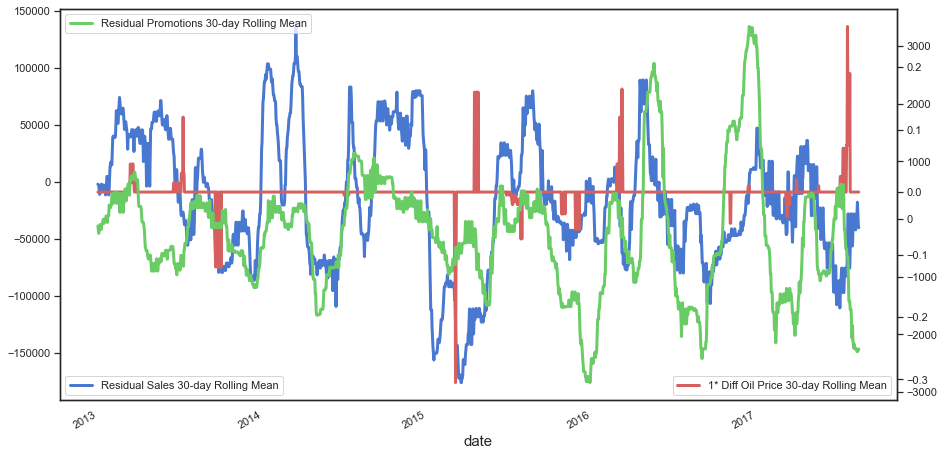

In [88]:
fig, ax1 = plt.subplots(figsize=(15, 8))
ax2 = ax1.twinx()
ax3 = ax1.twinx()

# agg_df.plot(y="sales_resid", ax=ax1, color="b", label="Total Daily sales")

agg_df.rolling(30, center=True, min_periods=7).median().\
    plot(y="sales_resid", ax=ax1, color="b", label="Residual Sales 30-day Rolling Mean", lw=3)

# agg_df.plot(y="oilprice_diff", ax=ax2, color="r", label="Daily Oil Price");

agg_df.rolling(30, center=True, min_periods=7).median().\
    plot(y="oilprice_diff", ax=ax2, color="r", label="1* Diff Oil Price 30-day Rolling Mean", lw=3)

agg_df.rolling(30, center=True, min_periods=7).median().\
    plot(y="promotion_resid", ax=ax3, color="g", label="Residual Promotions 30-day Rolling Mean", lw=3)

ax1.legend(loc="lower left");
ax2.legend(loc="lower right");

Next, we will test whether the residuals are auto-correlated. We use [Durbin-Watson statistic](https://www.statsmodels.org/dev/generated/statsmodels.stats.stattools.durbin_watson.html)

[More info on Durbin-Watson statistic](https://corporatefinanceinstitute.com/resources/data-science/durbin-watson-statistic/)

"The Durbin Watson statistic is a test statistic to detect autocorrelation in the residuals from a regression analysis."

"This statistic will always be between 0 and 4. **The closer to 0 the statistic, the more evidence for positive serial correlation. The closer to 4, the more evidence for negative serial correlation. A value of 2 indicates that there is no autocorrelation.**"

"As a general rule of thumb, **DW statistic value of 1.5 to 2.5 can be considered as normal.**"

In [89]:
dw_res = durbin_watson(agg_df[["sales_resid", "oilprice_diff", "promotion_resid"]].dropna())

for col, val in zip(["sales_resid", "oilprice_diff", "promotion_resid"], dw_res):
    print(col, ':', round(val, 2))

sales_resid : 1.19
oilprice_diff : 2.11
promotion_resid : 1.83


oilprice_diff and prmotion reisd are within acceptable values that shows these **residual** variables are not auto correlated. But sales_resid is way out of the acceptable values. I will difference the sales_resid values to remove any auto-correlation.

In [90]:
agg_df["sales_resid_diff"] = agg_df["sales_resid"].diff()

In [91]:
dw_res = durbin_watson(agg_df[["sales_resid_diff", "oilprice_diff", "promotion_resid"]].dropna())

for col, val in zip(["sales_resid_diff", "oilprice_diff", "promotion_resid"], dw_res):
    print(col, ':', round(val, 2))

sales_resid_diff : 2.23
oilprice_diff : 2.11
promotion_resid : 1.83


Now, all residual variables have no auto correlation.

In [ ]:
from statsmodels.tsa.api import VAR

model = VAR(agg_df[["sales_resid_diff", "oilprice_diff", "promotion_resid"]].dropna())

var_res = []

for i in np.arange(1, 32, 1):
    result = model.fit(i)
    var_res.append({"lag":i, "AIC" : result.aic})
    
pd.DataFrame(var_res).set_index("lag").sort_values("AIC")

In [ ]:
var_results = model.fit(maxlags=18, ic='aic')
var_results.summary()

In [ ]:
def granger_causality_test(x, maxlag, alpha):
    
    results = grangercausalitytests(
        x=x.dropna(), 
        maxlag=maxlag, 
        verbose=True
    )
    
    res_dict = [{"lag" : i+1, "Pval" : results[i+1][0]["ssr_ftest"][1]} for i in range(maxlag)]
    
    pd.options.display.float_format = '{:.6f}'.format
    res_dict_df = pd.DataFrame(res_dict)
    
    print()
    print(f"Are there any significant P-Value?: {any(res_dict_df['Pval'] < alpha)}")
    
    return res_dict_df.set_index("lag")

In [ ]:
granger_causality_test(x=agg_df[["sales_resid_diff", "oilprice_diff"]], maxlag=7, alpha=0.01)

In [ ]:
granger_causality_test(x=agg_df[["sales_resid_diff", "promotion_resid"]], maxlag=7, alpha=0.01)

In [ ]:
granger_causality_test(x=agg_df[["promotion_resid", "oilprice_diff"]], maxlag=7, alpha=0.01)